In [35]:
%reset
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
import glob
import os
import scipy.misc
import scipy
import pickle
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [2]:
def load_images(test_root, gt_root):
    test_images = []
    gt_images = []
    cnt_1 = 0
    cnt_2 = 0
    for image_name in glob.glob(f'{test_root}/*.jpg'):
        test_image = mpimg.imread(image_name)
        if test_image.shape[0] == 321 and cnt_1 != 50:
            cnt_1 += 1
            _, t = os.path.split(image_name)
            filename = os.path.splitext(t)[0]
            
            gt_img = sio.loadmat(f'{gt_root}{filename}')
            gt = np.empty((0,321,481))
            for i in range(5):
                gt = np.concatenate((gt, gt_img['groundTruth'][0][i][0][0][0].reshape((1,321,481))))
            
            test_images.append(test_image)
            gt_images.append(gt)
        else:
            cnt_2 += 1
    return np.asarray(test_images), np.asarray(gt_images)

In [3]:
def display_image_and_gt(images, gt, idx):
    f, axes = plt.subplots(2,3,figsize=(20,10))
    r,c=2,3
    
    for i in range(2):
        for j in range(3):
            if (i,j) == (0,0):
                axes[0,0].imshow(images[idx],aspect='auto')
                axes[0,0].axis('off')
                continue
            axes[i,j].imshow(gt[idx,r*i+j-1],aspect='auto')
            axes[i,j].axis('off')
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    plt.show()

In [4]:
def display_clustered_and_gt(clustered, gt, idx):
    f, axes = plt.subplots(2,3,figsize=(20,10))
    r,c=2,3

    for i in range(2):
        for j in range(3):
            if (i,j) == (0,0):
                axes[0,0].imshow(clustered[idx*5+2],aspect='auto')
                axes[0,0].axis('off')
                continue
            axes[i,j].imshow(gt[idx,r*i+j-1],aspect='auto')
            axes[i,j].axis('off')
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    plt.show()

In [66]:
def display_image_and_image(images1, images2, idx):
    f, axes = plt.subplots(1,2,figsize=(20,10))
    
    axes[0].imshow(images1[idx],aspect='auto')
    axes[0].axis('off')
    axes[1].imshow(images2[idx*5+2],aspect='auto')
    axes[1].axis('off')

    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    plt.show()

In [5]:
def rel_diff(x, y):
    return abs(x-y)/max(x,y)

def k_means(points, k=3, threshold=0.001, max_iters=100, dist_func='euclidean'):
    '''
        returns a numpy array with the centroid of each point at its index in the
        points array, and an array containing the centroids
    '''
    
    dist = {'euclidean':euclidean_distances, 'manhattan':manhattan_distances}[dist_func]
    # assume points are gaussian and pick k random points from the destribution as the centroids
    centroids = np.random.randn(k, points.shape[1])
    prev_loss = 1e9
    for i in range(max_iters):
        dists_to_centroids = dist(X=points, Y=centroids)
        assignment = np.argmin(dists_to_centroids, axis=1)
        loss = np.sum(np.linalg.norm(centroids[assignment] - points, axis=1)**2)
        if rel_diff(loss, prev_loss) <= threshold:
            break
        prev_loss = loss
        # update the centroids
        for cent_idx in range(k):
            cent_points = points[np.where(assignment==cent_idx)]
            if cent_points.shape[0] > 0: # to protect against when no points belong to the centroid
                centroids[cent_idx] = np.mean(cent_points, axis=0)
        
    return assignment, centroids, loss

def k_means_rep(points, k=3, threshold=0.001, max_iters=100, dist_func='euclidean', reps=1, ):
    min_loss = 1e15
    best_centroids, best_assignment = None, None
    for rep in range(reps):
        assignment, centroids, loss = k_means(points=points, k=k, threshold=threshold, max_iters=max_iters, dist_func=dist_func)
        if loss <= min_loss:
            min_loss, best_centroids, best_assignment = loss, centroids, assignment
    return best_assignment, best_centroids, min_loss

In [6]:
def segment_images(test, root, added_f=0):
    file_exists = os.path.isfile(root)
    
    if not file_exists:
        assignments = []
        xx = np.arange(321)
        yy = np.arange(481)
        X, Y = np.meshgrid(yy, xx)
        
        for i in range (0,test.shape[0]):
            for k in [3,5,7,9,11]:
                if added_f ==0:
                    pixel_map = test[i].reshape(test[i].shape[0]*test[i].shape[1],test[i].shape[2])
                    assignment, _, _ = k_means_rep(points=pixel_map, k=k, reps=5)
                else:
                    pixel_map = np.concatenate((Y.reshape(321,481,1),X.reshape(321,481,1),test[i]),axis=2)
                    assignment, _, _ = k_means_rep(points=pixel_map.reshape(-1,pixel_map.shape[2]), k=k, reps=5)
                z = assignment.reshape((321,481))
                z = np.rot90(z,2)
                z = np .fliplr(z)

                fig = plt.figure()
                h = plt.contourf(X,Y,z)
                plt.axis('off')
                plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    #             plt.imsave(f'./Images/{i}_{k}.jpg', z, origin='lower', cmap=h.get_cmap)
                plt.savefig(f'./Images/{i}_{k}.jpg')
    #             scipy.misc.imsave(f'./Images/{i}_{k}.jpg', z)

                assignments.append(z)
        ass_array = np.asarray(assignments)
        np.save(root, ass_array)
        return ass_array
    
    else:
        ass_array = np.load(root)
        return ass_array
    

In [7]:
#Conditional Entropy
def cond_entropy(p, c):
    clusters, counts = np.unique(c, return_counts=True)
    count = dict(zip(clusters, counts))
    H = 0
    for i in clusters:
#         print("cluster : ", i)
        h = 0
        occurances = {}
        posx,posy = np.where(c == i)
        for j in range(0,len(posx)):
            idx,idy = posx[j],posy[j]
            if p[idx][idy] not in occurances.keys():
                occurances[p[idx][idy]] = 1
            else:
                occurances[p[idx][idy]] += 1
#         print(occurances)
        for key in occurances.keys():
            h -= (occurances[key]/count[i])*np.log10(occurances[key]/count[i])
#         print("h is ", h)
        H += (count[i]/(c.shape[0]*c.shape[1])) * h
#         print("H is ", H)
    return (1/clusters.shape[0]) * H


In [19]:
def f_measure(images_segmented,gt):
    print(gt.shape)
    f_measure_allsamples= []
    j = 0
    for i  in range (0,images_segmented.shape[0],5):
        f_measure_avgM=[]
        for k in range (i,i+5):
            f_measure_KforeachM= []
            ground_truth = gt[j]
            for M in range (0,ground_truth.shape[0]):
                
                clusters, ccounts = np.unique(images_segmented[k], return_counts=True)
                F= 0
#                 print(clusters)
#                 print(ccounts)
                for s in range (0,clusters.shape[0]):
                    pos = np.where(images_segmented[k]==clusters[s])
                    partition= ground_truth[M][pos]

                    partitions, pcounts = np.unique(partition, return_counts=True)

                    gtpartitions,gtcounts= np.unique(ground_truth[M],return_counts=True)

                    idx = np.argmax(pcounts)
                    lookfor= partitions[idx]

                    current= np.where(gtpartitions==lookfor)
                    currentCount = gtcounts[current]
                    purity =(np.amax(pcounts))/partition.shape[0]
                    recall = (np.amax(pcounts))/currentCount

                    F += (2*purity*recall)/(purity+recall)
#                 print(f'F:{F}') 
                f_measure_KforeachM.append(F)
            f_measure_avgM.append(np.average(f_measure_KforeachM))
#         print(f'avgM:{f_measure_avgM}') 
        f_measure_allsamples.append(f_measure_avgM)      
        j+=1 
    result = np.asarray(f_measure_allsamples)
    result = result.reshape((50,5))
    return result

In [80]:
def spectral_segment(img, resize_percent=1, n_clusters=5,add_spatial=False):
    img = scipy.misc.imresize(img,resize_percent) / 255
    h,w,_=img.shape
    xx = np.arange(w)
    yy = np.arange(h)
    X, Y = np.meshgrid(yy, xx)
    pixel_map = np.concatenate((Y.reshape(h,w,1),X.reshape(h,w,1),img),axis=2)
    if not add_spatial:
        pixel_map = img
    cluster_idx =  SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                                      n_neighbors=n_clusters,
                                      n_jobs=-1, eigen_solver='arpack').fit_predict(pixel_map.reshape(-1,pixel_map.shape[-1]))
    return cluster_idx.reshape(img.shape[0],img.shape[1])

def evaluate_spectral(images, resize_percent=1, n_images=5, n_clusters=5,add_spatial=False):
    clustered_images = []
    for i in range(n_images):
        clustered_images.append(spectral_segment(images[i], resize_percent, n_clusters,add_spatial))
        with open(f'spectral_labels_{i}.pkl', 'wb+') as f:
            pickle.dump(clustered_images[-1], f)
        print(f'clustered image {i}')
    return clustered_images

# def spectral_segment(img, resize_percent=1, n_clusters=5, n_neighbors=5, add_spatial=False):
#     img = scipy.misc.imresize(img,resize_percent)
#     h,w,_=img.shape
#     xx = np.arange(w)
#     yy = np.arange(h)
#     X, Y = np.meshgrid(yy, xx)
#     pixel_map = np.concatenate((Y.reshape(h,w,1),X.reshape(h,w,1),img),axis=2)
#     if not add_spatial:
#         pixel_map = img
#     cluster_idx =  SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
#                                       n_neighbors=n_neighbors,
#                                       n_jobs=-1, eigen_solver='arpack').fit_predict(pixel_map.reshape(-1,pixel_map.shape[-1]))
#     return cluster_idx.reshape(img.shape[0],img.shape[1])

In [9]:
root_test, root_gt = 'BSR_bsds500/BSR/BSDS500/data/images/test/', 'BSR_bsds500/BSR/BSDS500/data/groundTruth/test/'
root_images = 'gt_seg.npy'
root_added_f = 'gt_seg_added_f.npy'

test, ground_truth = load_images(root_test, root_gt)
ground_truth.shape

(50, 5, 321, 481)

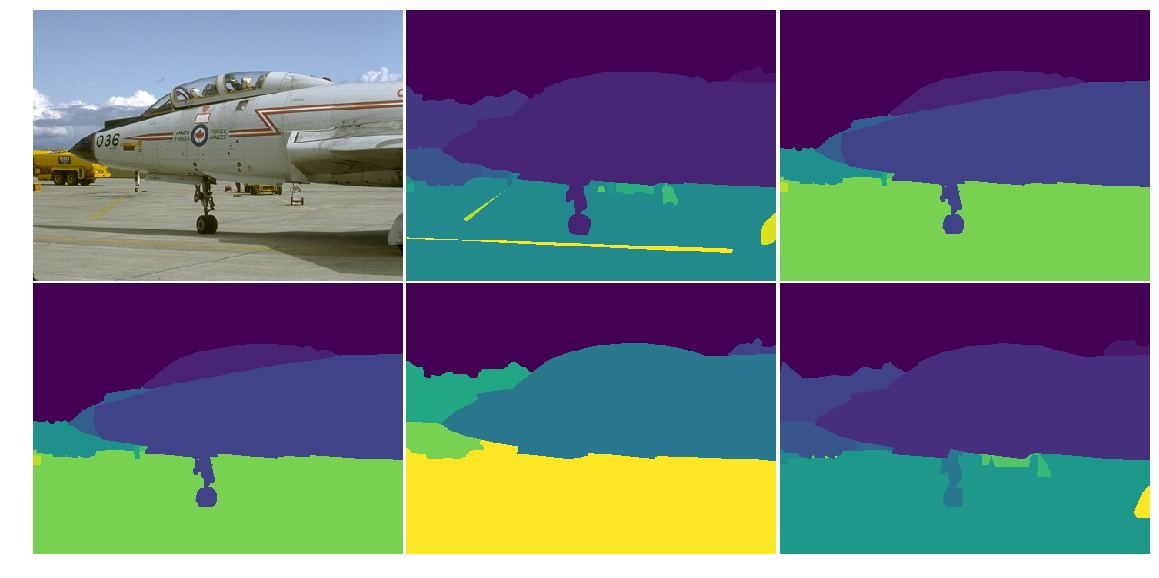

In [10]:
display_image_and_gt(test,ground_truth, 2)

**K-means Clustering**

In [11]:
a = segment_images(test,root_images,added_f=0)

#### *F-measure*

In [20]:
f_measures = f_measure(a,ground_truth)

In [21]:
print("F-measure:\n")
print(np.average(f_measures))
print(np.amax(f_measures))
print(np.amin(f_measures))

F-measure:

2.363224534172896
4.433928353041247
0.9803499211508646


#### *Conditional Entropy*

In [16]:
avg = []
for i in range(0,a.shape[0]):
    k=i%5
    print("evaluating image ", str(int(i/5)), " with k = ", str((2*k+3)))
    average = 0
    for j in range(ground_truth.shape[1]):
        average += cond_entropy(ground_truth[int(i/5)][j], a[i])
    average = average/ground_truth.shape[1]
    avg.append(average)

evaluating image  0  with k =  3
evaluating image  0  with k =  5
evaluating image  0  with k =  7
evaluating image  0  with k =  9
evaluating image  0  with k =  11
evaluating image  1  with k =  3
evaluating image  1  with k =  5
evaluating image  1  with k =  7
evaluating image  1  with k =  9
evaluating image  1  with k =  11
evaluating image  2  with k =  3
evaluating image  2  with k =  5
evaluating image  2  with k =  7
evaluating image  2  with k =  9
evaluating image  2  with k =  11
evaluating image  3  with k =  3
evaluating image  3  with k =  5
evaluating image  3  with k =  7
evaluating image  3  with k =  9
evaluating image  3  with k =  11
evaluating image  4  with k =  3
evaluating image  4  with k =  5
evaluating image  4  with k =  7
evaluating image  4  with k =  9
evaluating image  4  with k =  11
evaluating image  5  with k =  3
evaluating image  5  with k =  5
evaluating image  5  with k =  7
evaluating image  5  with k =  9
evaluating image  5  with k =  11
eval

evaluating image  48  with k =  7
evaluating image  48  with k =  9
evaluating image  48  with k =  11
evaluating image  49  with k =  3
evaluating image  49  with k =  5
evaluating image  49  with k =  7
evaluating image  49  with k =  9
evaluating image  49  with k =  11


In [17]:
print("Conditional Entropy:\n")
print(np.average(avg))
print(np.min(avg))
print(np.max(avg))

Conditional Entropy:

0.09197186425256262
0.008863031784950296
0.3084896410946373


**Spectral Clustring**

In [37]:
clustered_images = evaluate_spectral(test, 0.30,n_images=5)

/home/mohamedmahmoud/myprograms/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/home/mohamedmahmoud/myprograms/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


clustered image 0
clustered image 1
clustered image 2
clustered image 3
clustered image 4


#### *Conditional Entropy for Spectral Clustering*

In [70]:
avg = []
for i in range(0,np.asarray(clustered_images).shape[0]):
    k=i%5
    print("evaluating image ", str(int(i/5)), " with k = ", str((2*k+3)))
    average = 0
    for j in range(ground_truth.shape[1]):
        average += cond_entropy(ground_truth[int(i/5)][j], a[i])
    average = average/ground_truth.shape[1]
    avg.append(average)

evaluating image  0  with k =  3
evaluating image  0  with k =  5
evaluating image  0  with k =  7
evaluating image  0  with k =  9
evaluating image  0  with k =  11


In [71]:
print("Conditional Entropy:\n")
print(np.average(avg))
print(np.min(avg))
print(np.max(avg))

Conditional Entropy:

0.10987929039189201
0.05410309250143319
0.2124680454908193


#### *Comparisons*

**K-means vs Ground Truth**

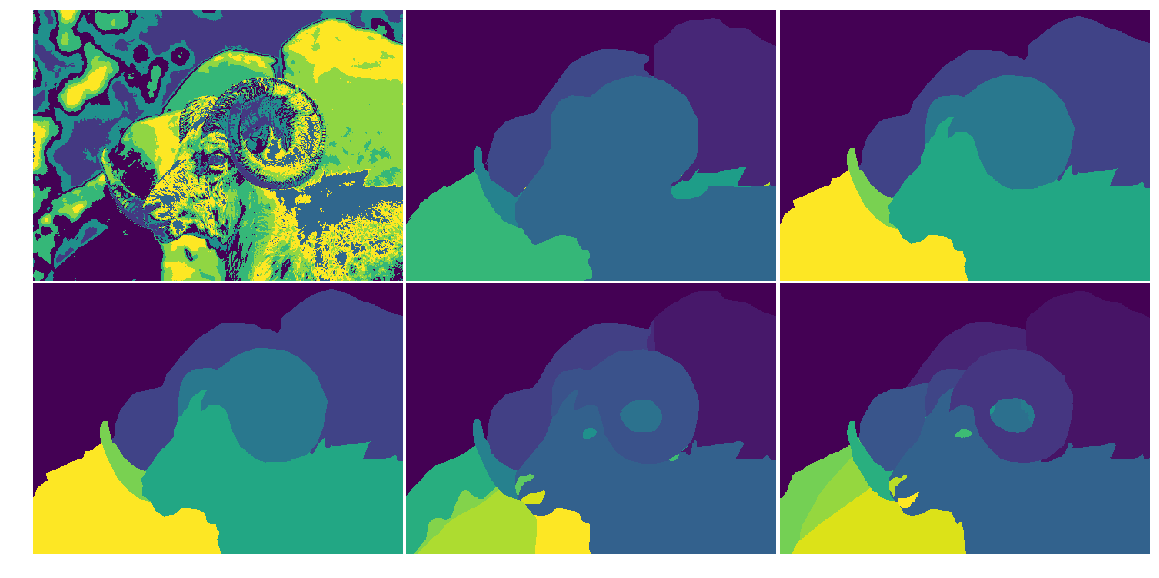

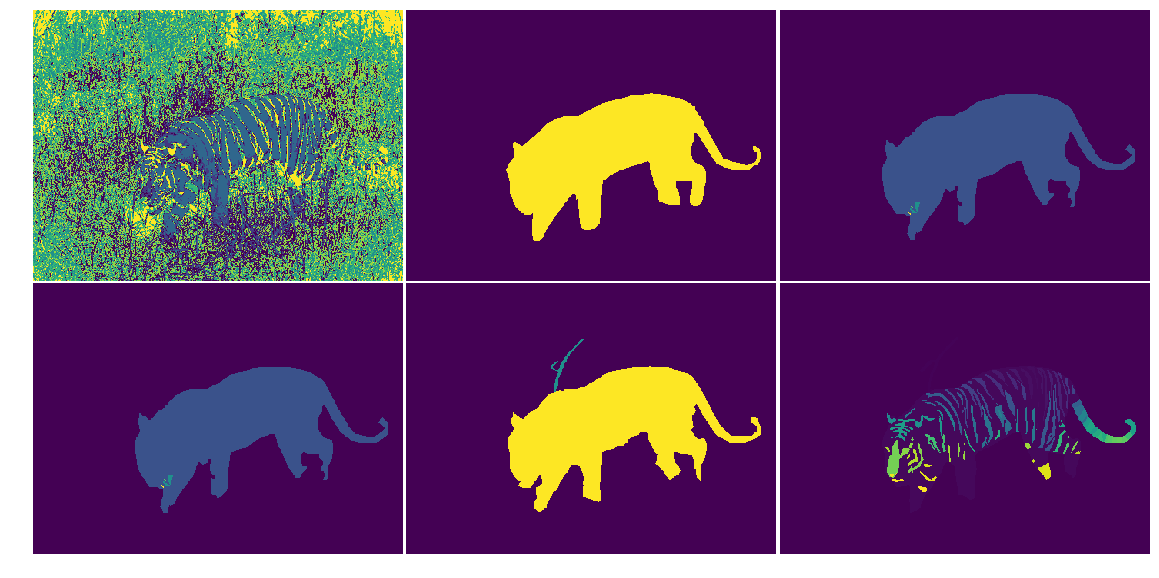

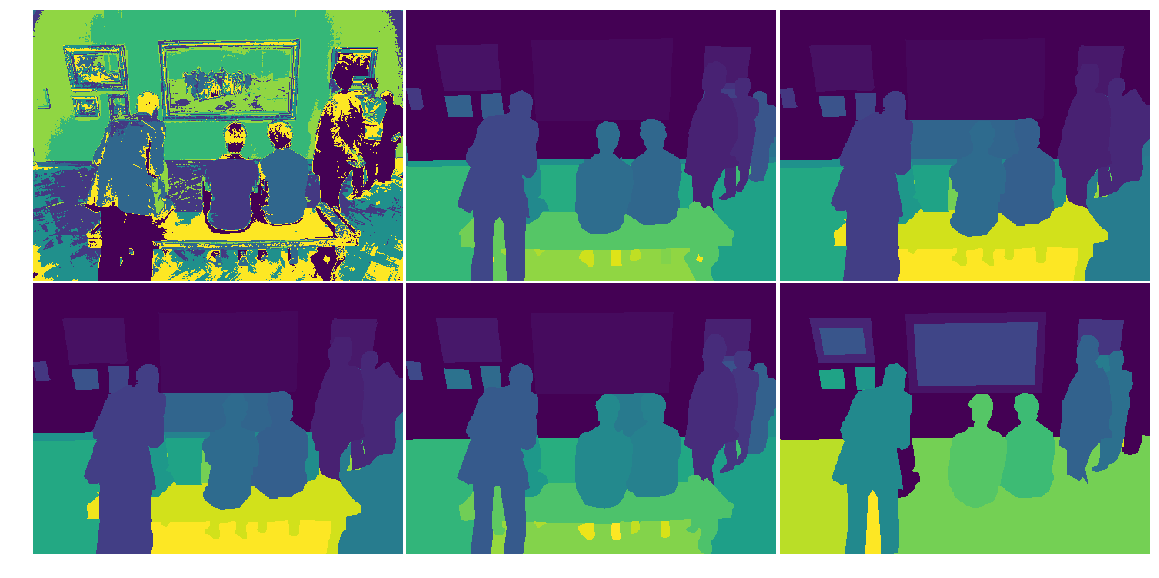

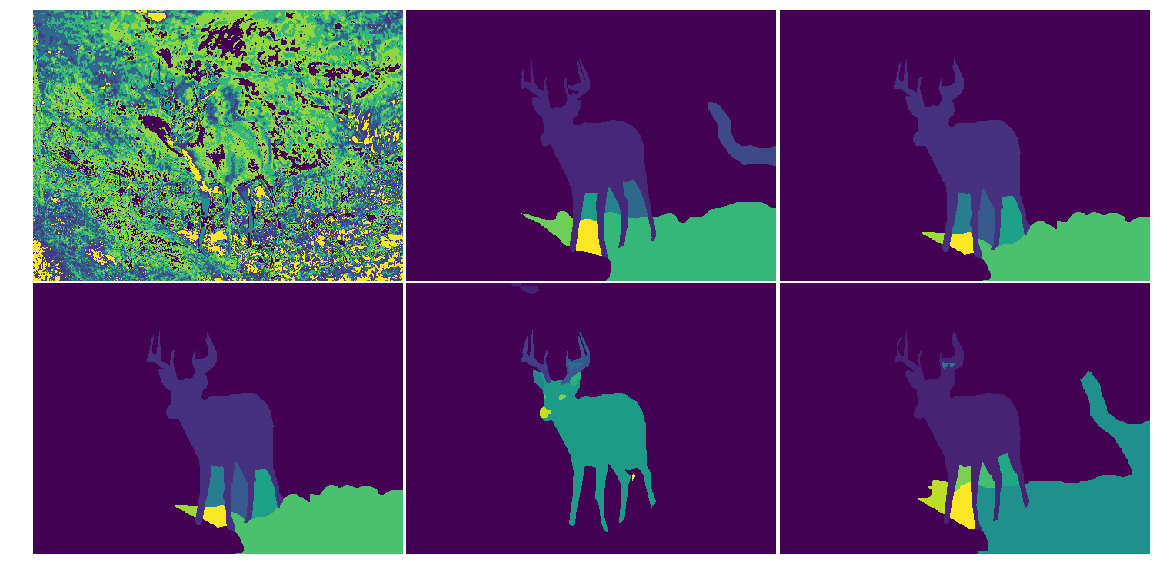

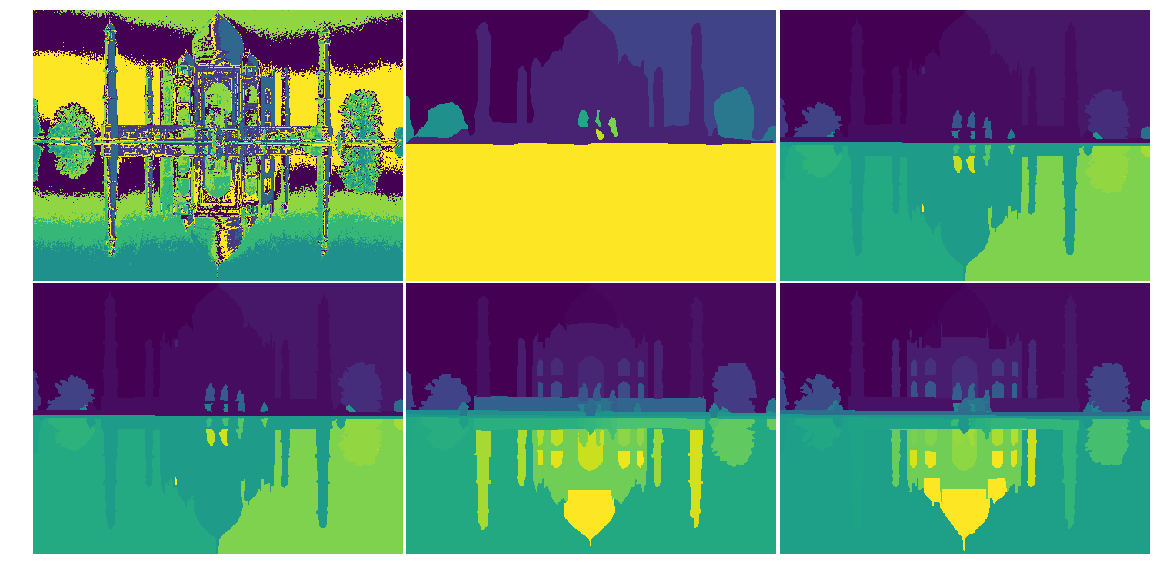

In [22]:
for i in range(0,5):
    display_clustered_and_gt(a,ground_truth,5+2*i)

**Spectral Clustring vs Ground Truth**

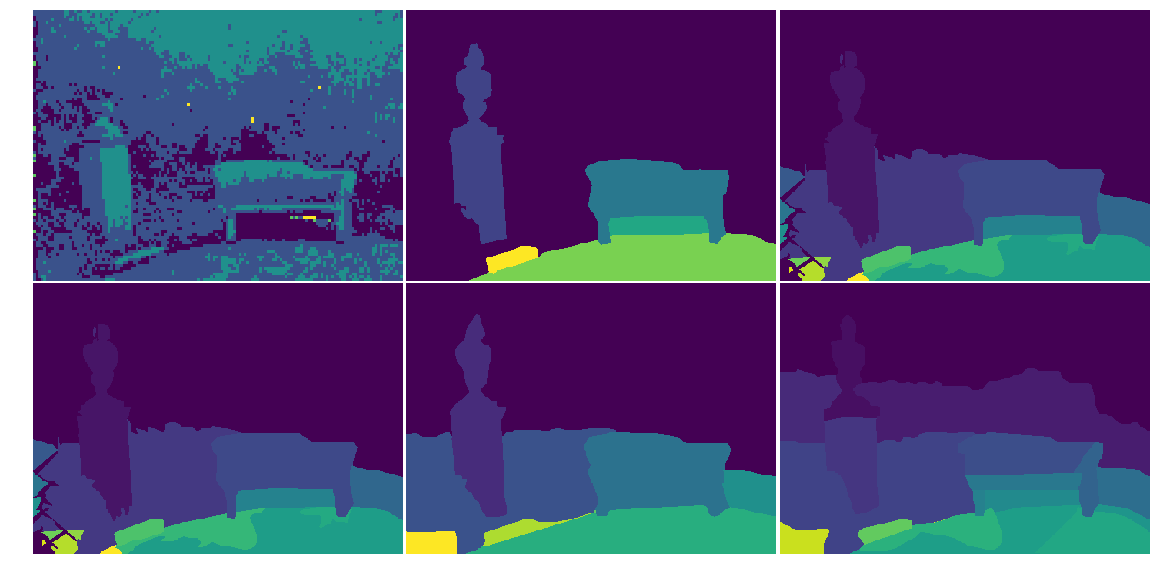

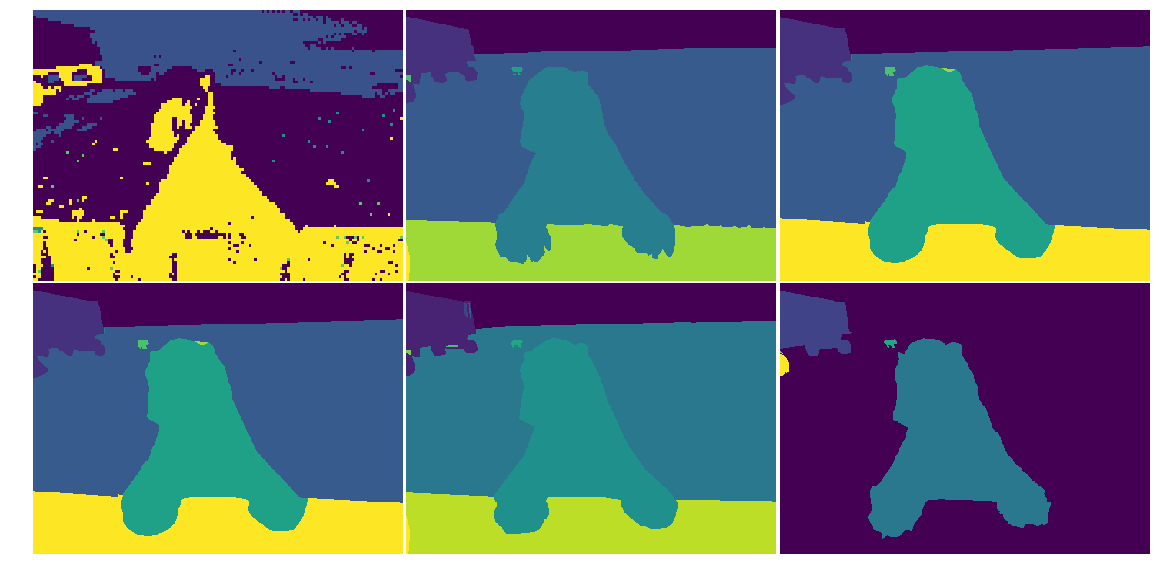

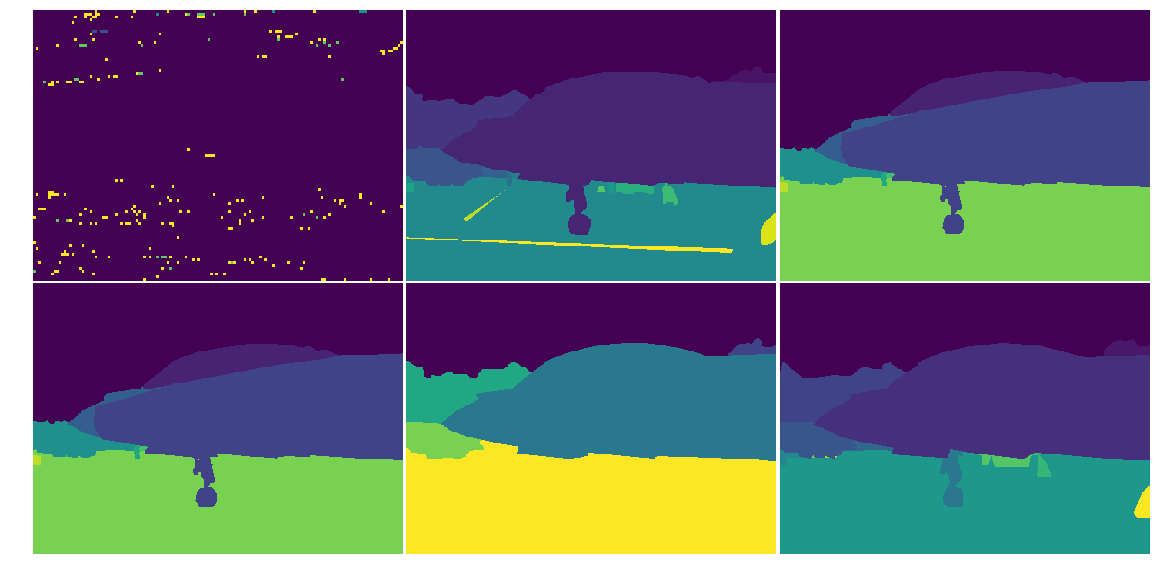

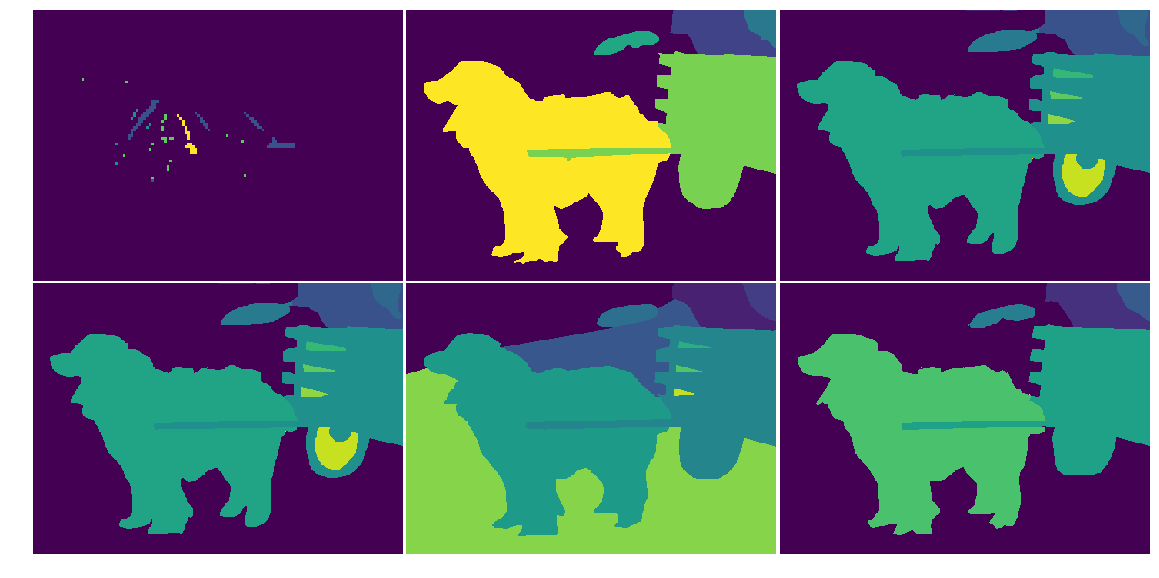

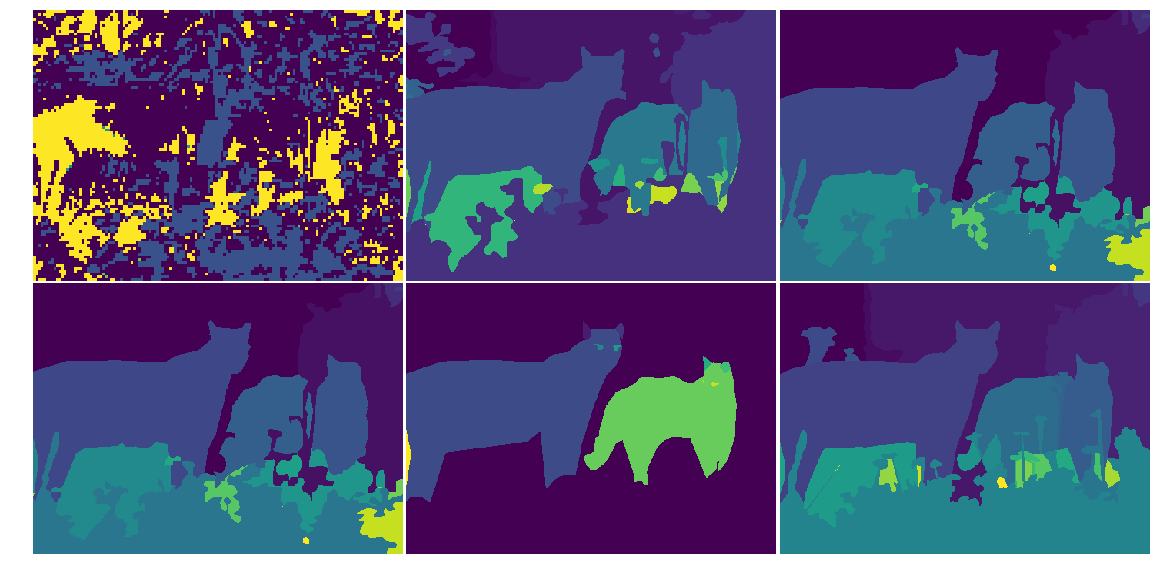

In [45]:
for i in range(0,5):
    display_image_and_gt(clustered_images,ground_truth,i)

**K-means vs Spectral Clustering**

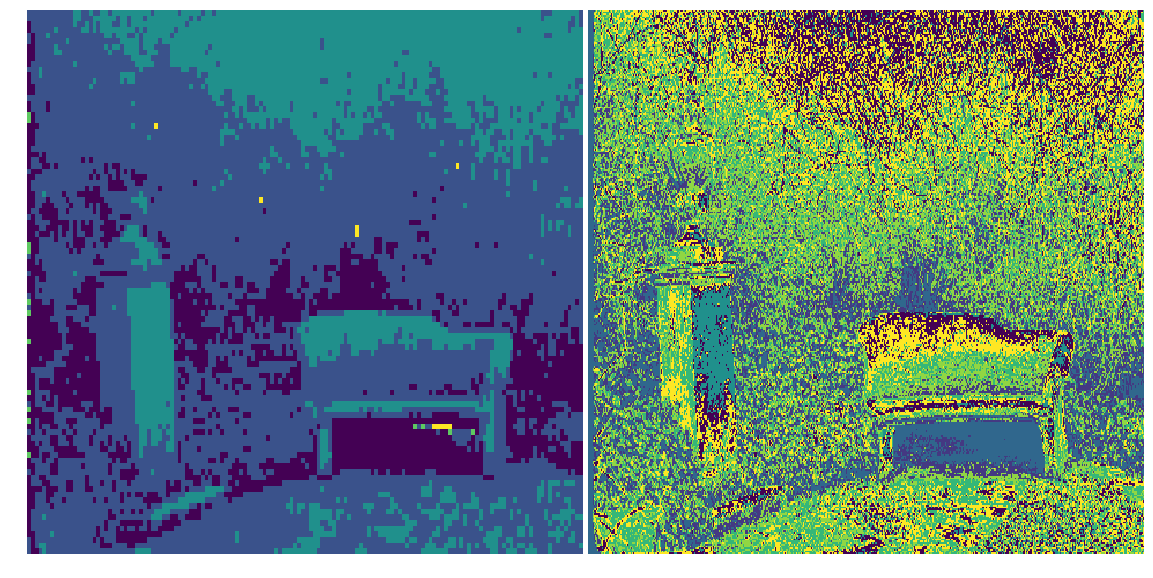

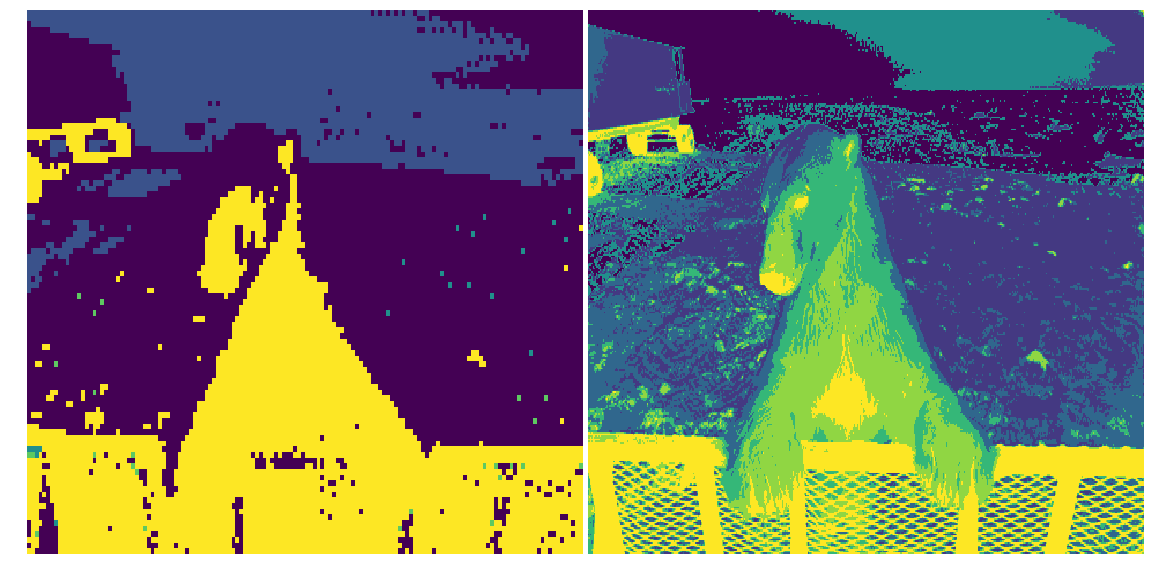

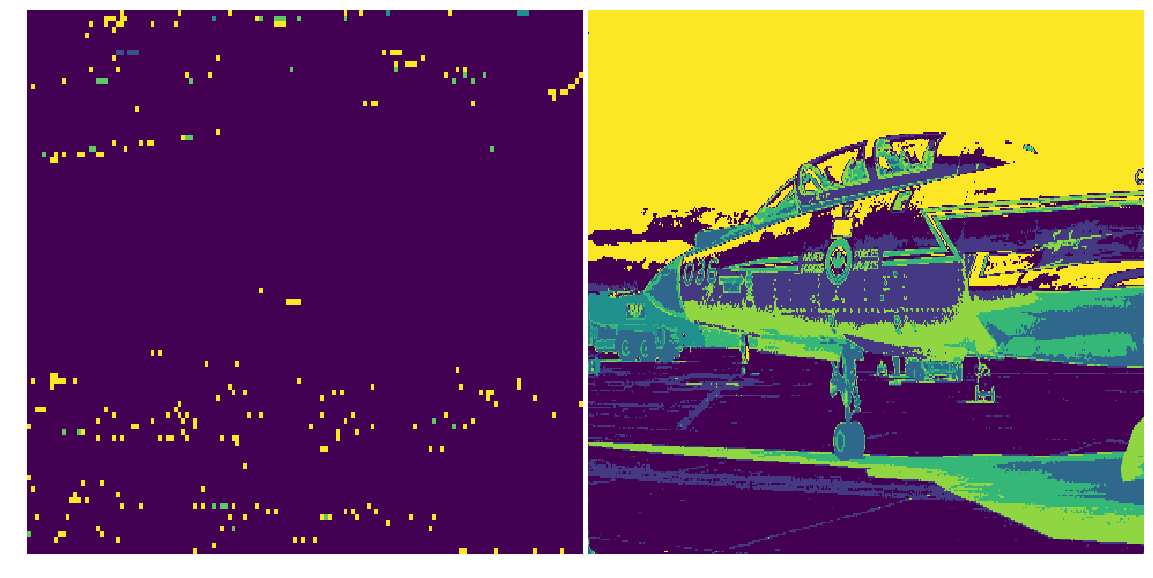

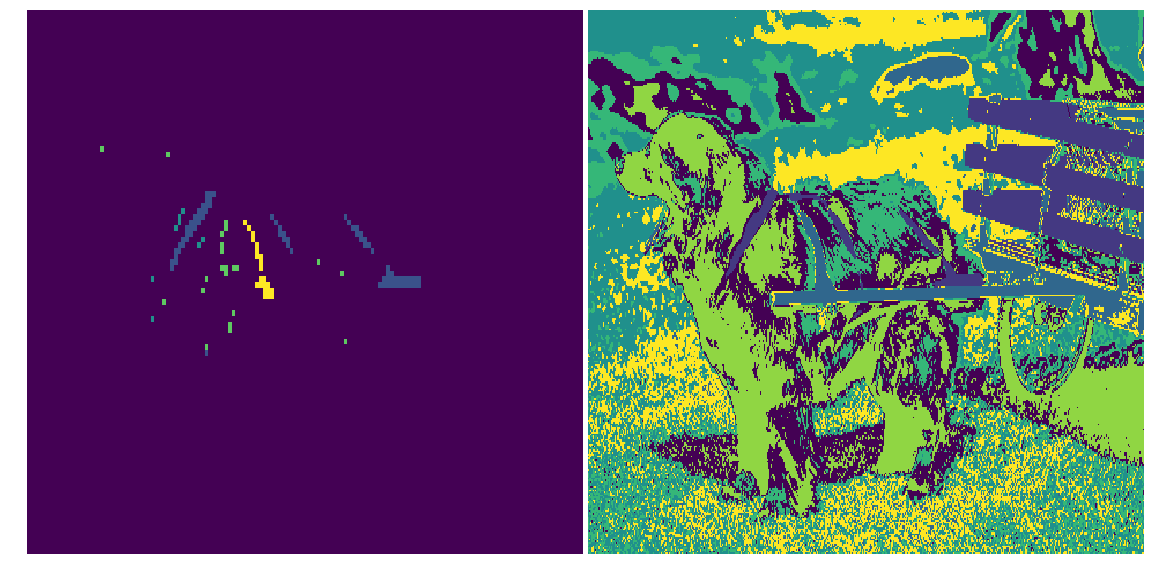

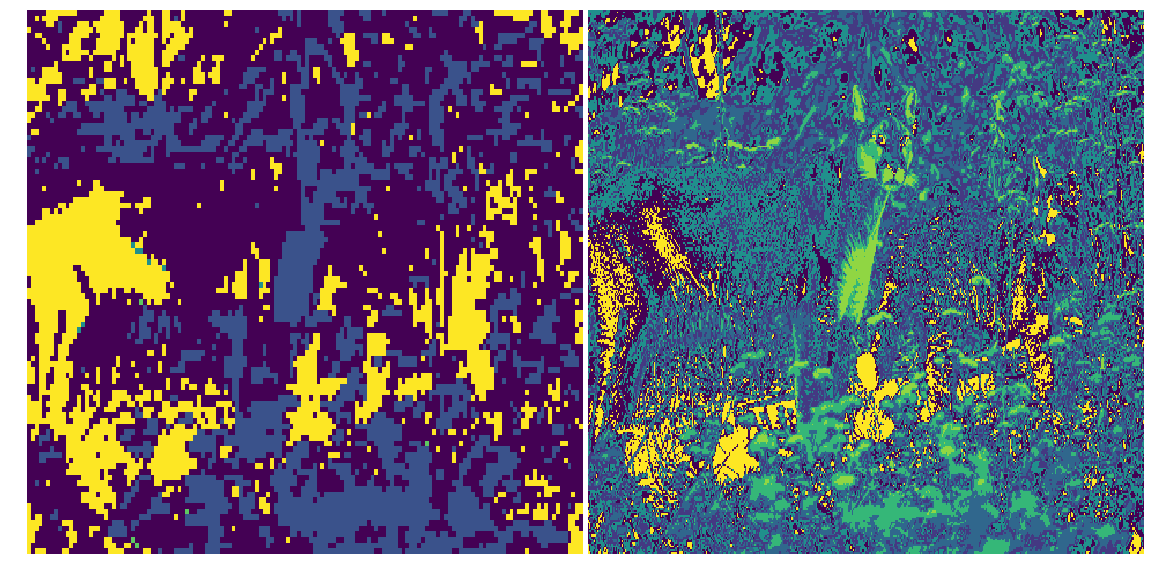

In [67]:
for i in range(0,5):
    display_image_and_image(clustered_images,a,i)

### **Extra**

**K-means with spatial features**

/home/mohamedmahmoud/myprograms/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


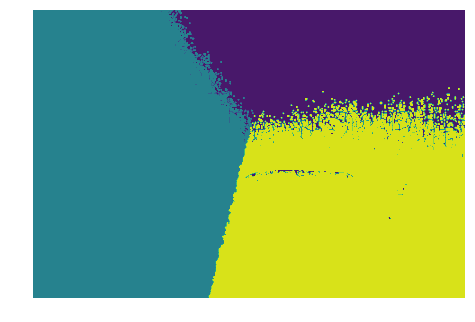

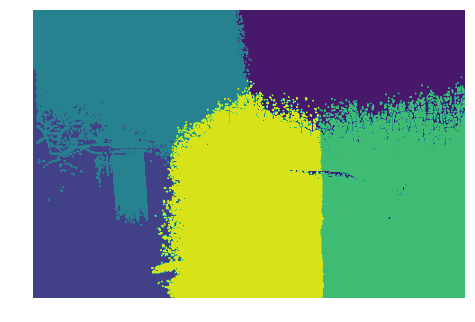

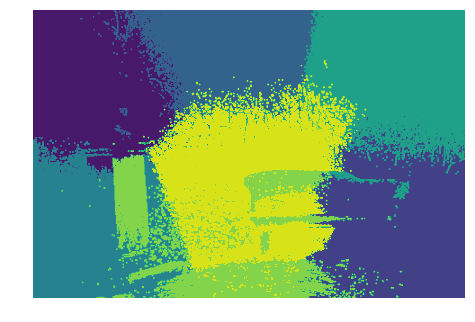

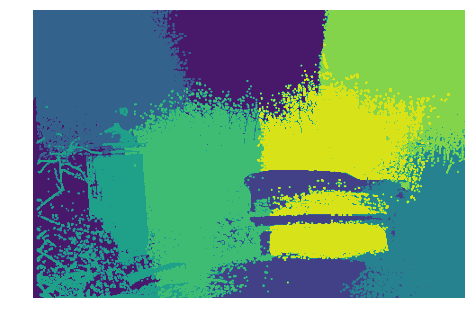

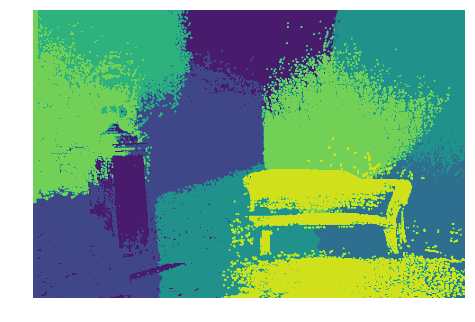

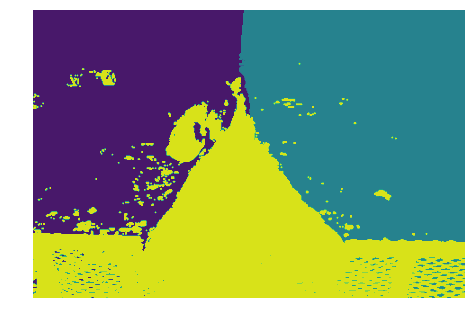

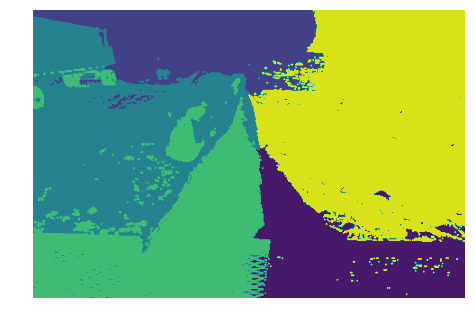

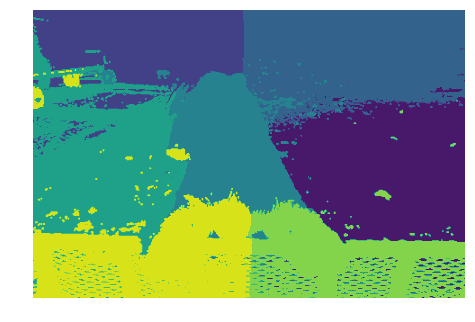

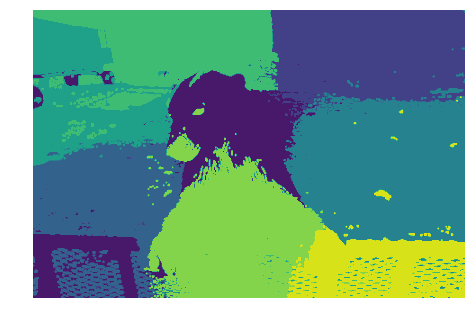

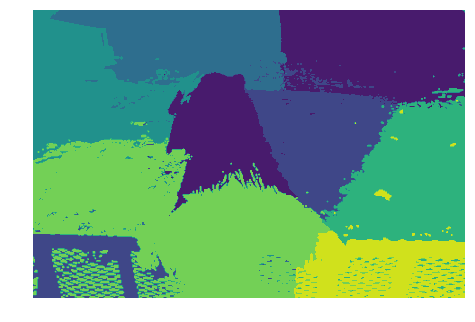

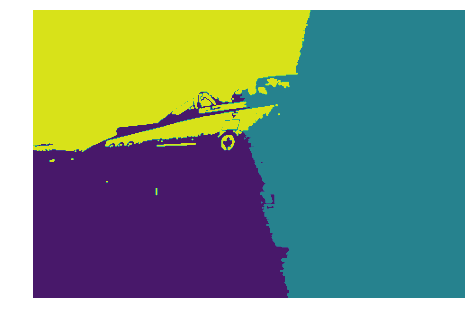

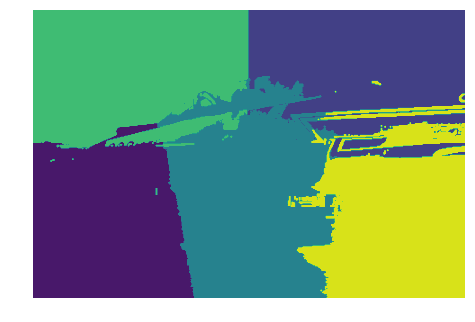

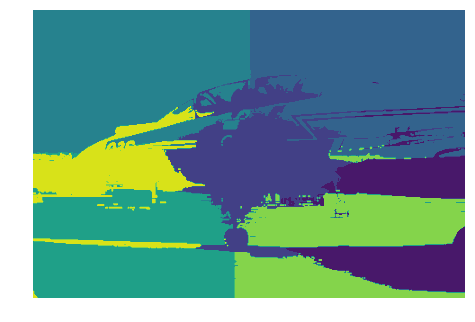

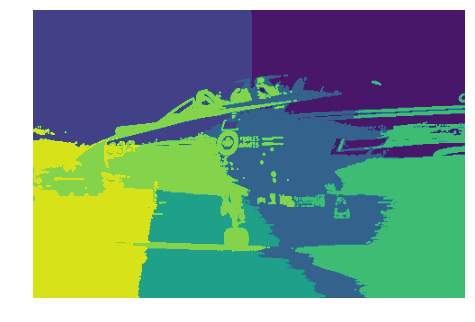

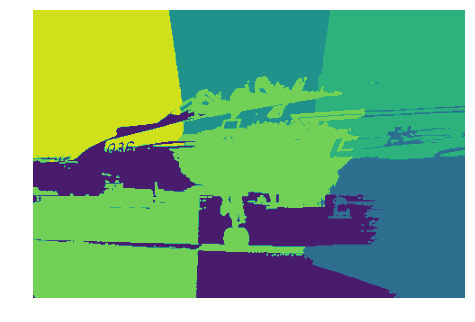

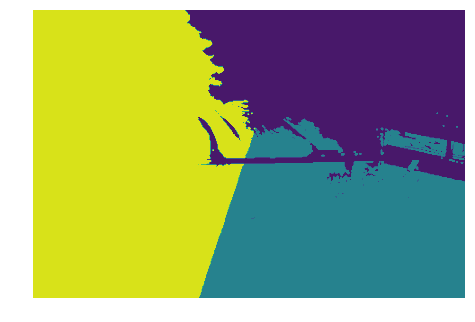

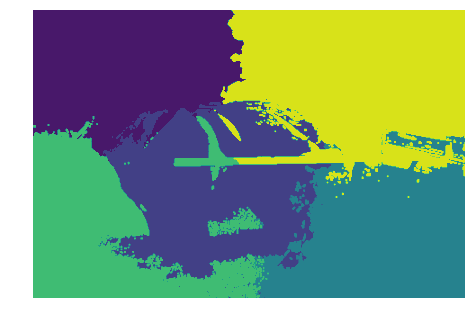

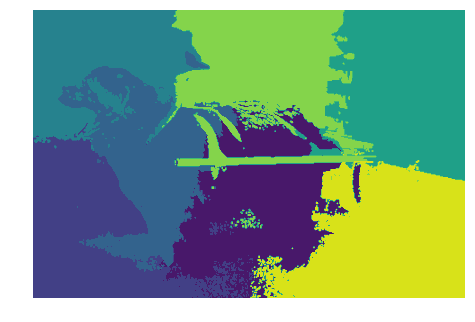

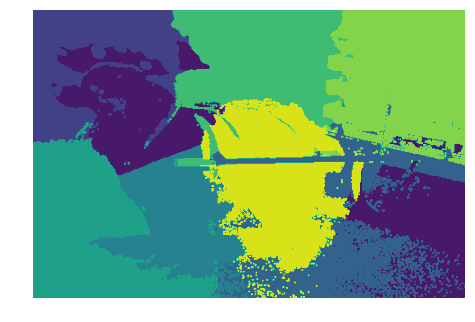

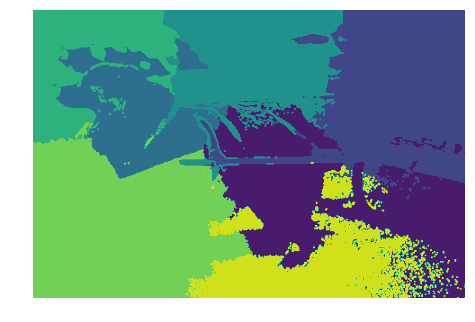

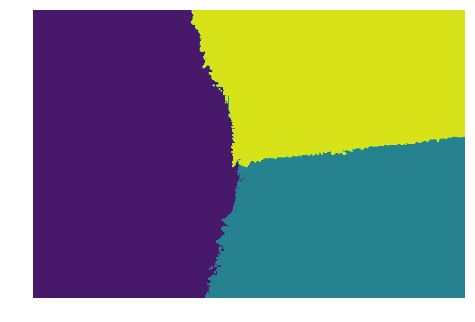

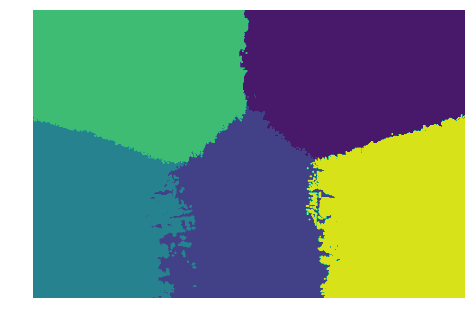

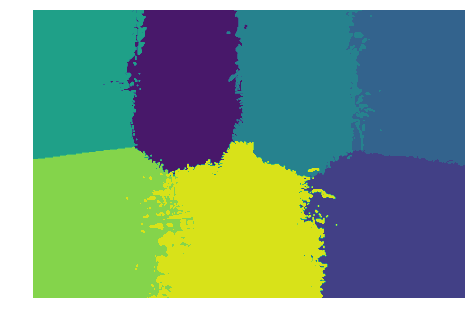

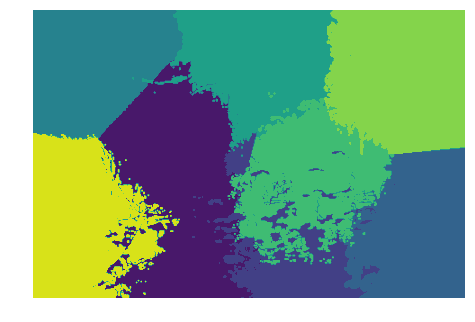

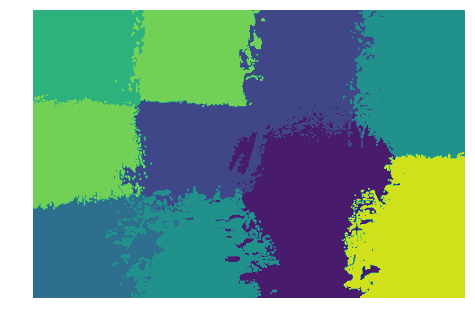

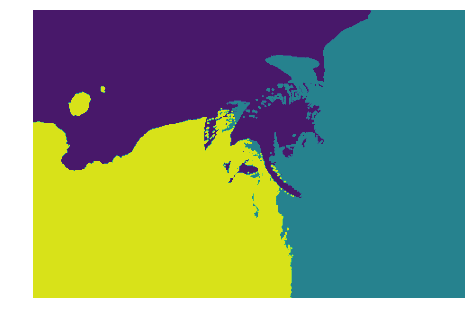

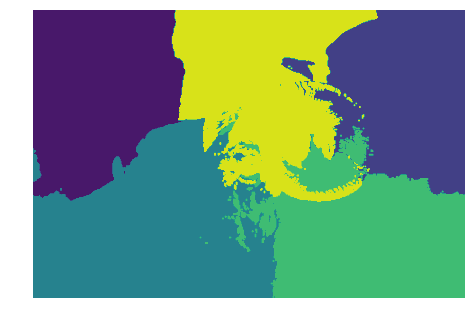

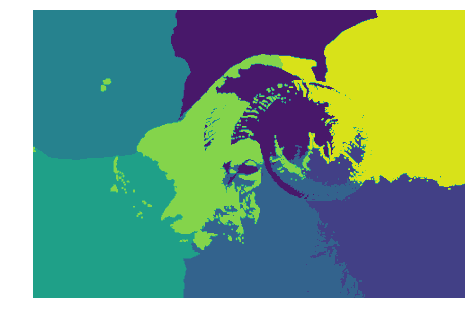

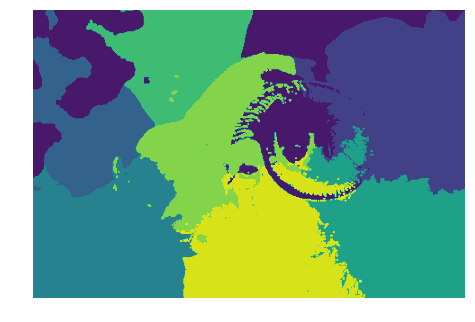

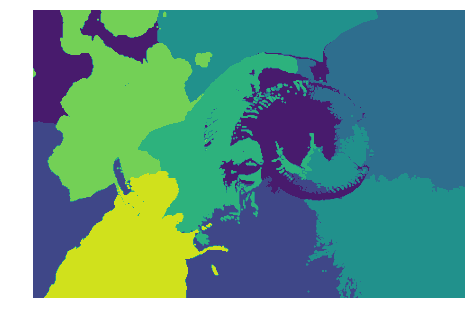

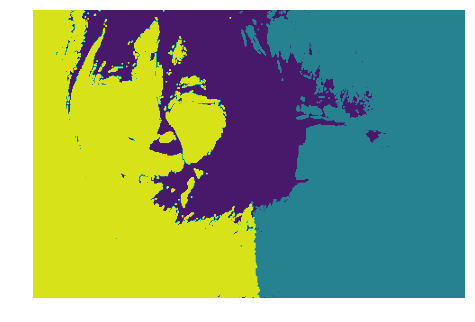

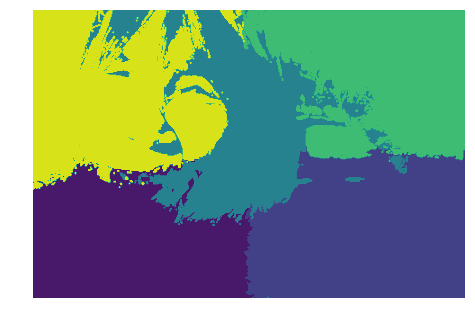

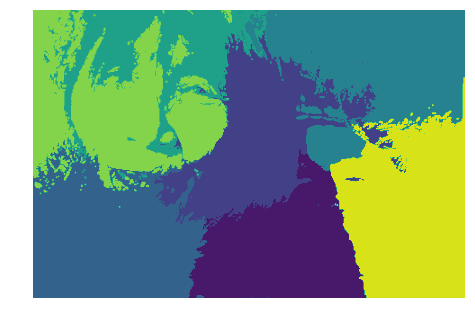

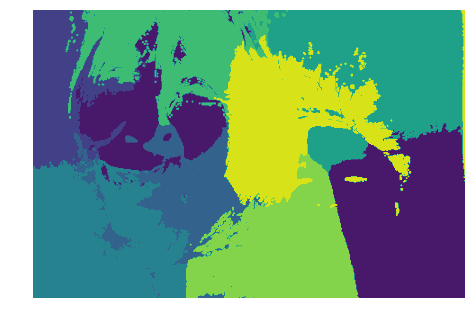

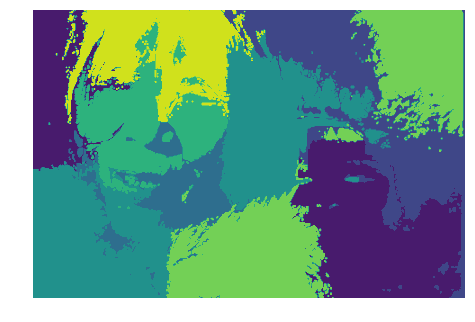

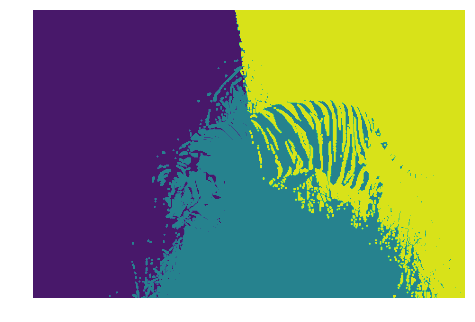

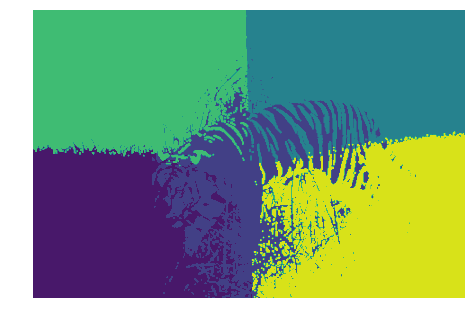

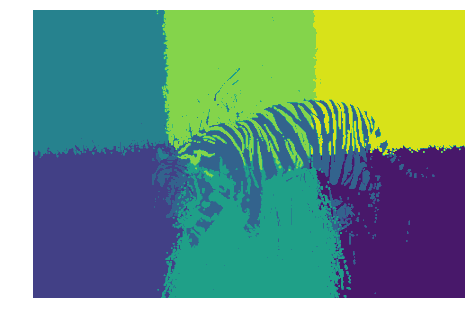

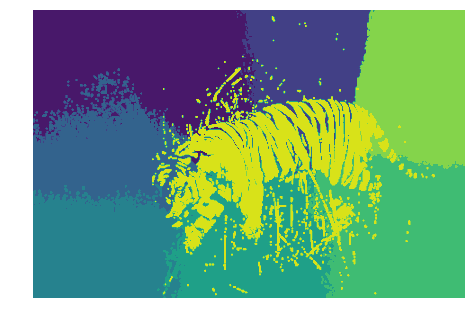

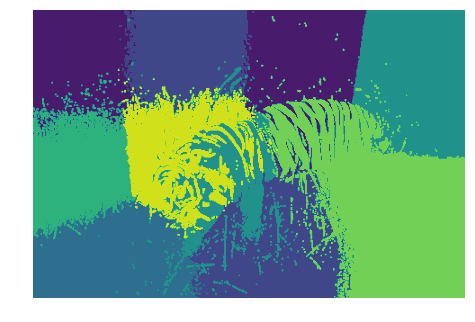

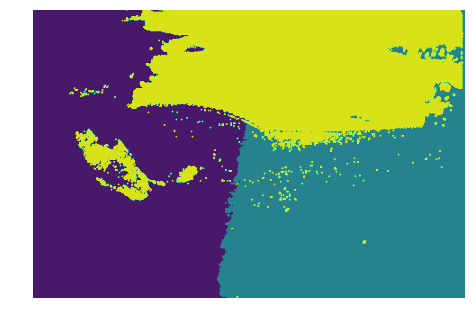

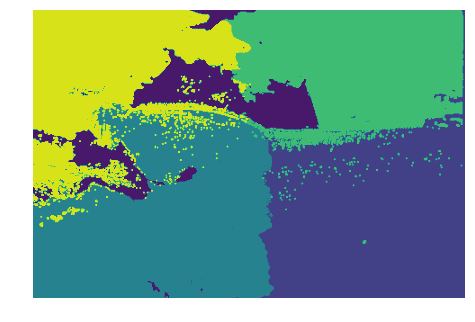

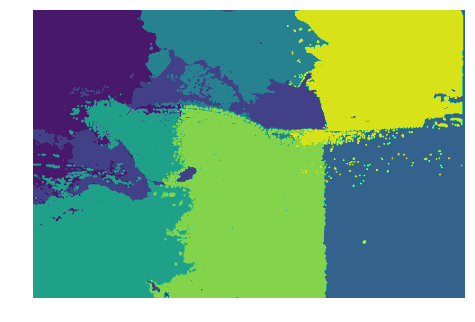

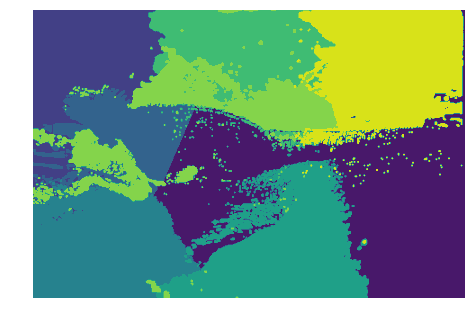

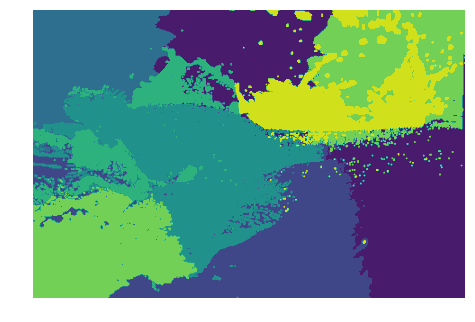

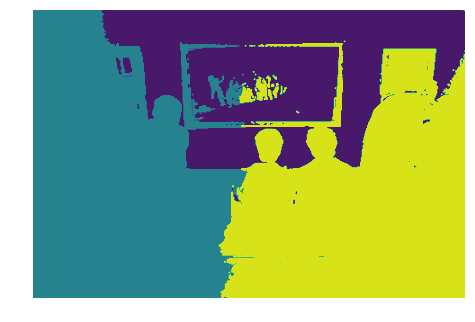

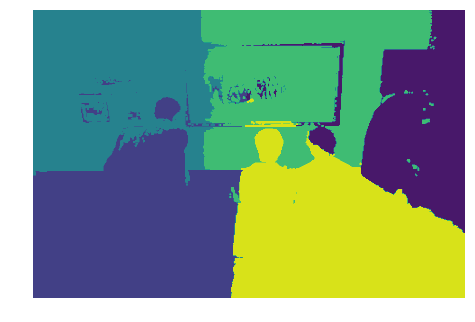

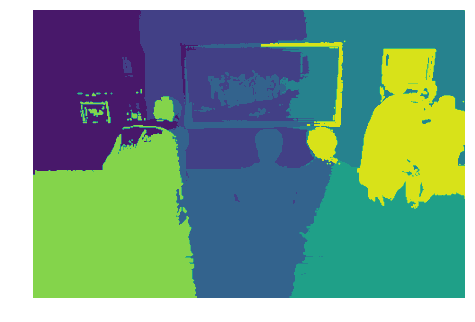

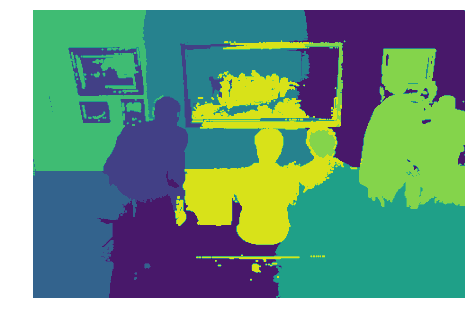

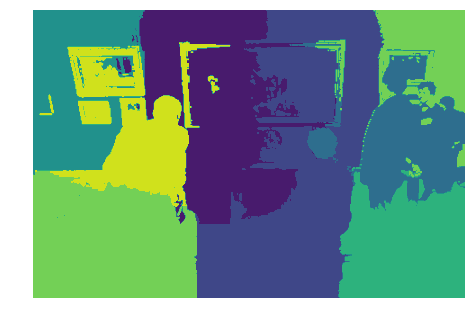

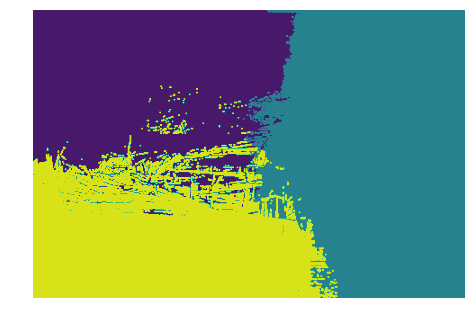

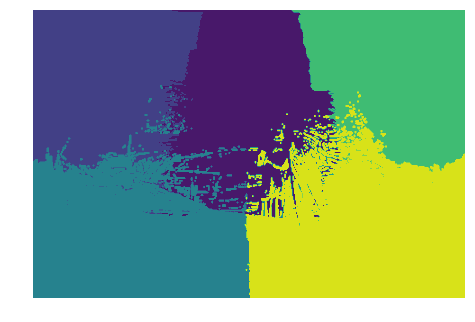

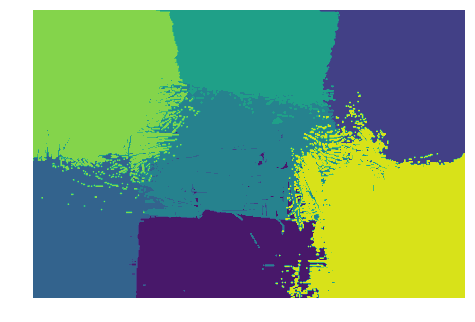

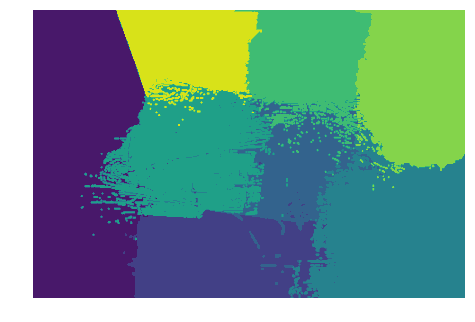

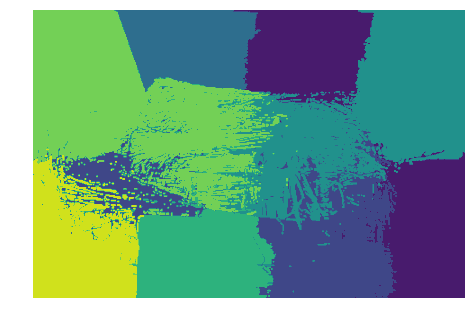

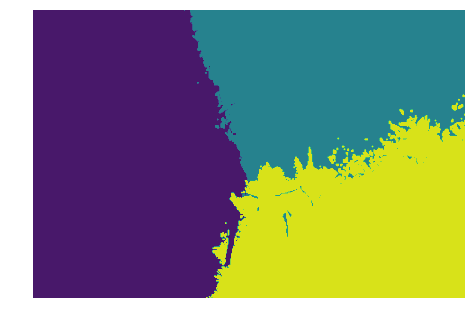

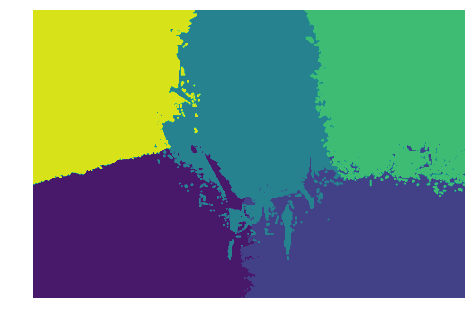

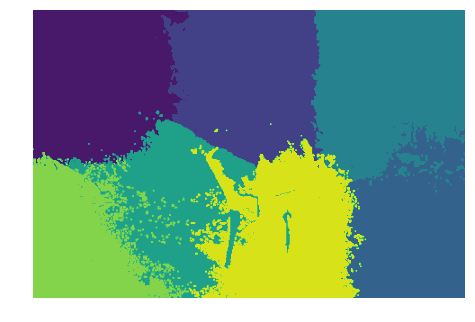

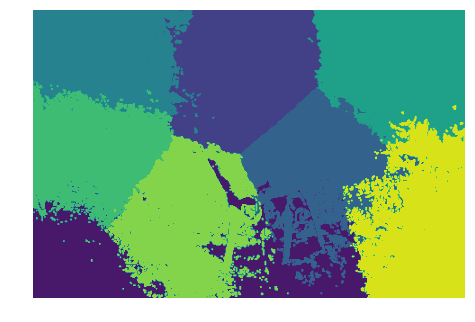

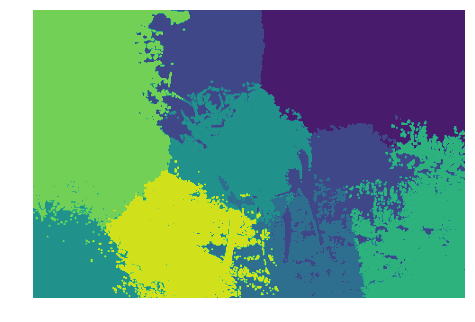

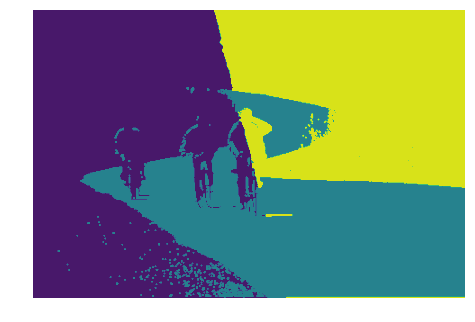

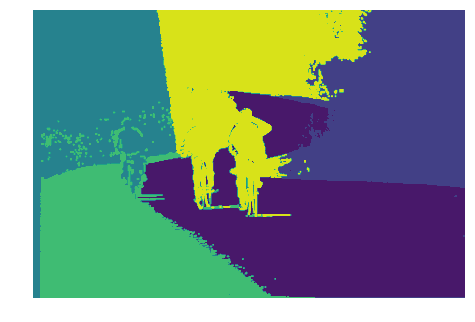

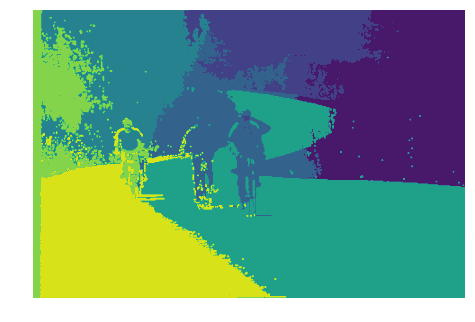

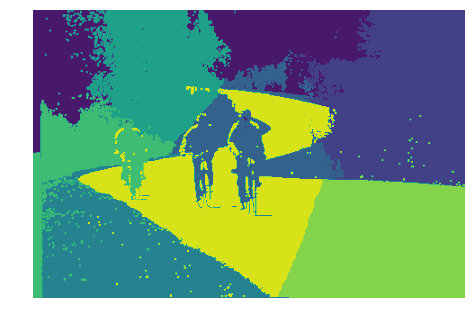

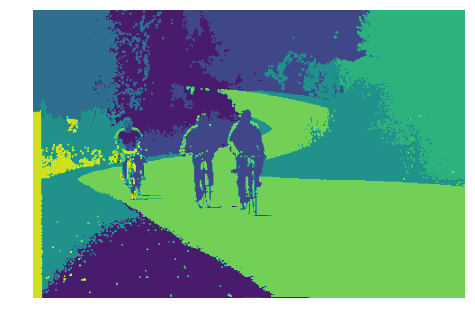

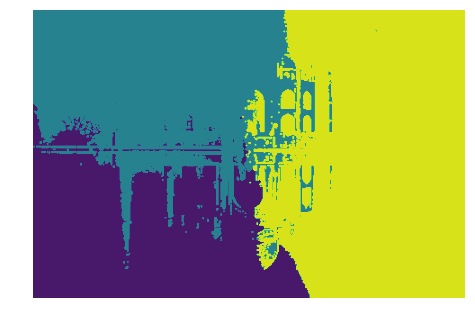

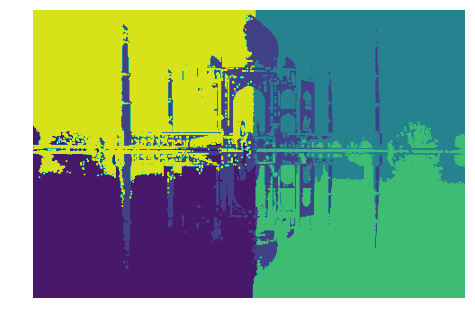

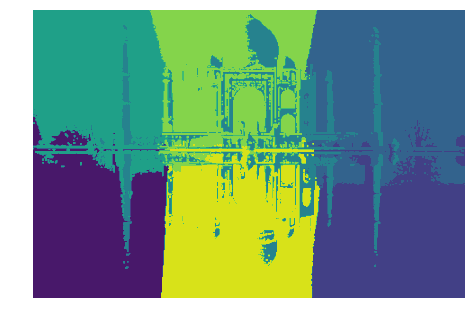

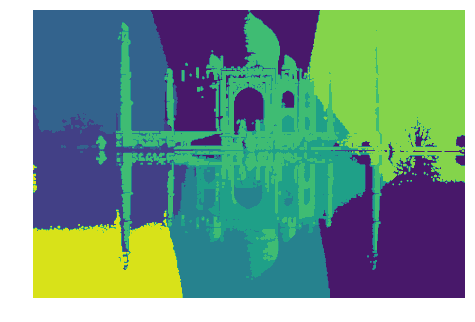

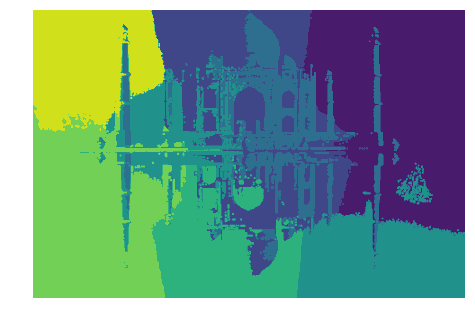

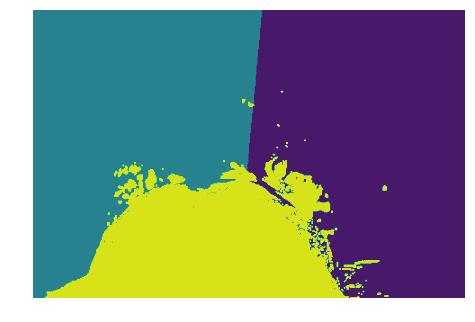

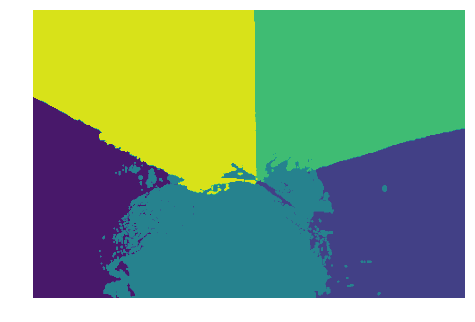

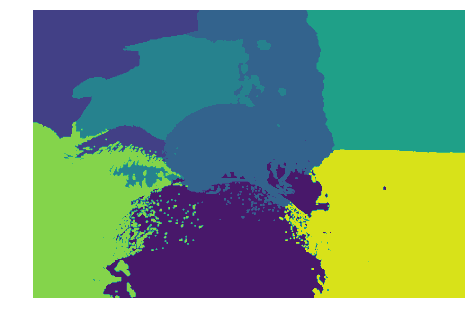

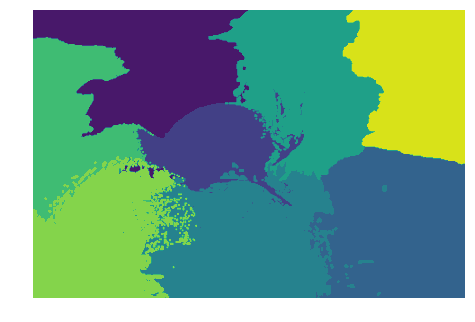

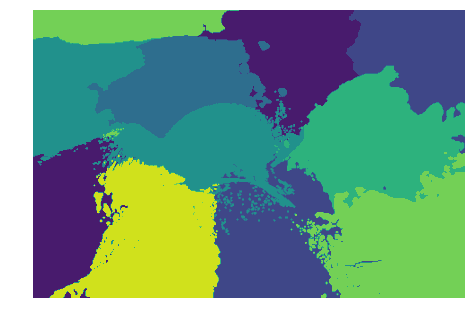

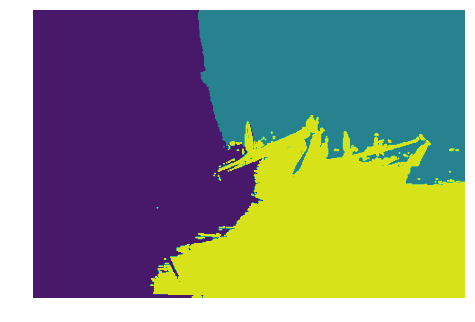

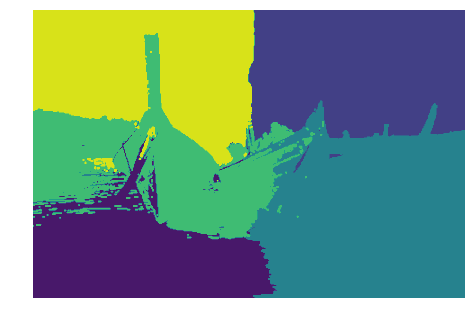

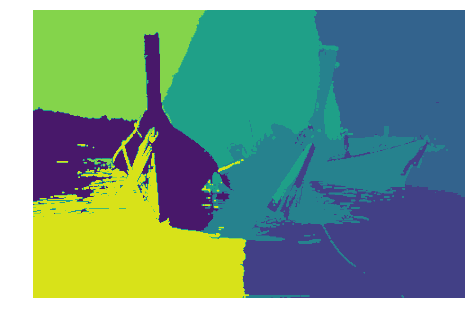

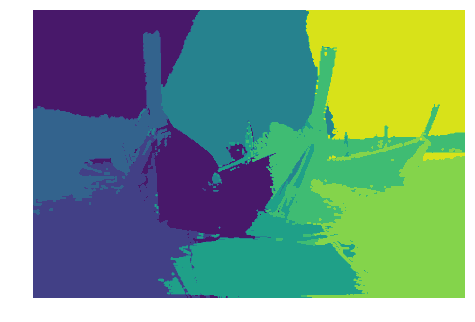

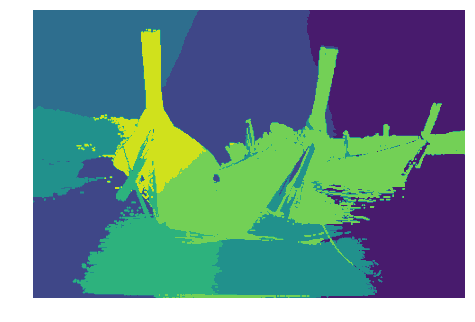

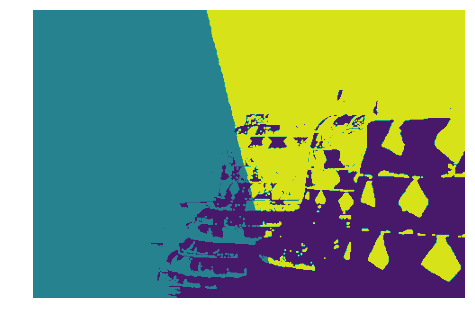

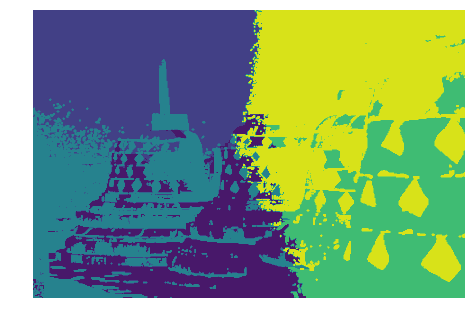

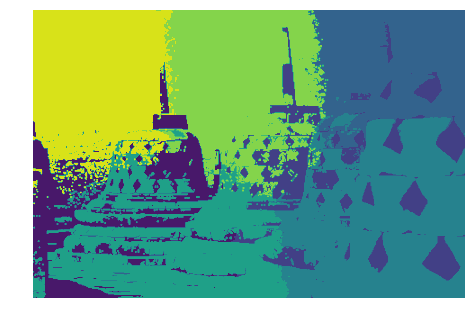

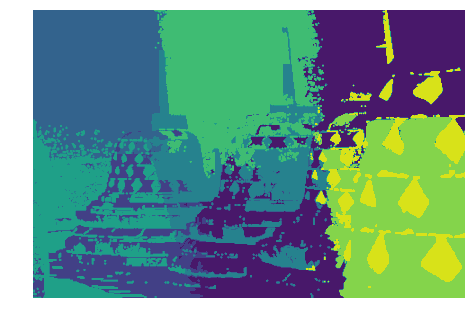

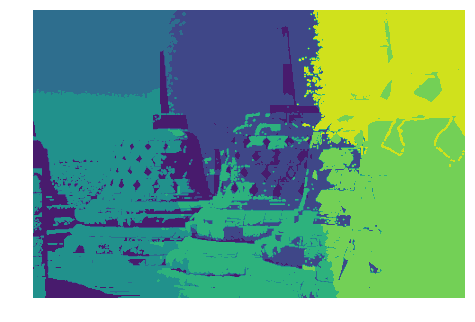

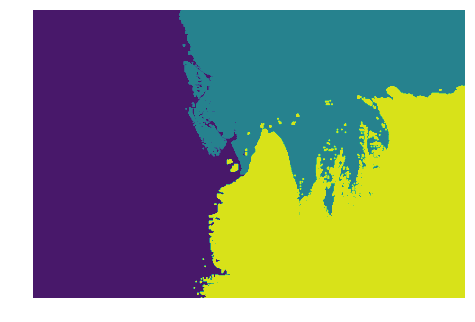

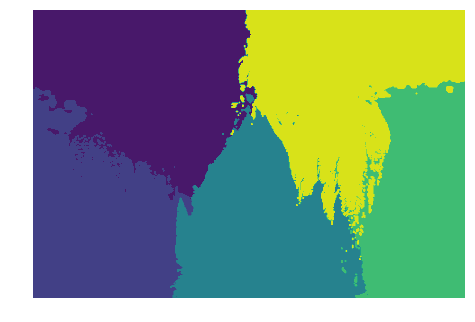

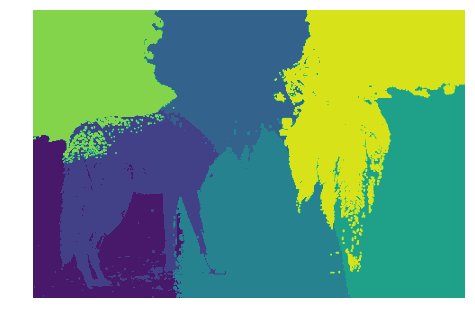

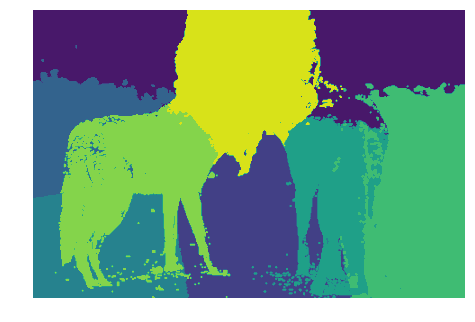

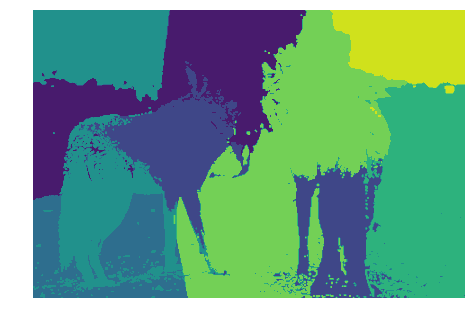

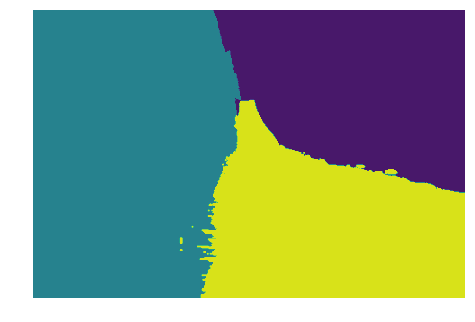

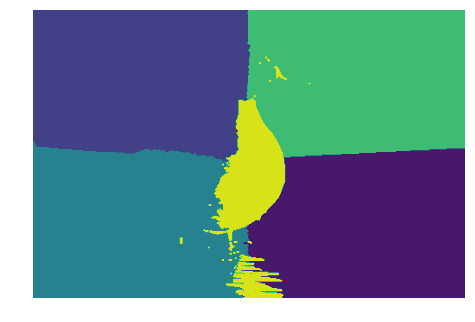

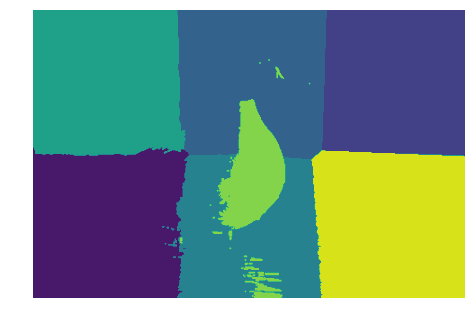

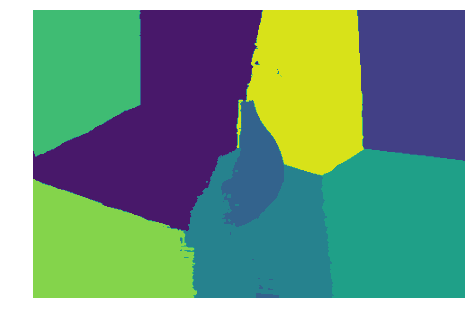

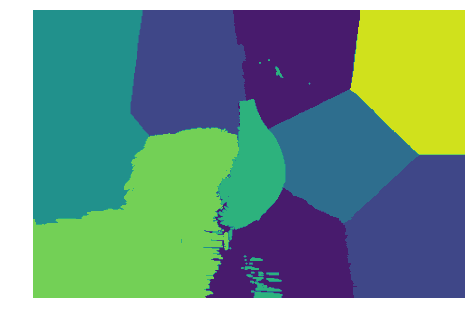

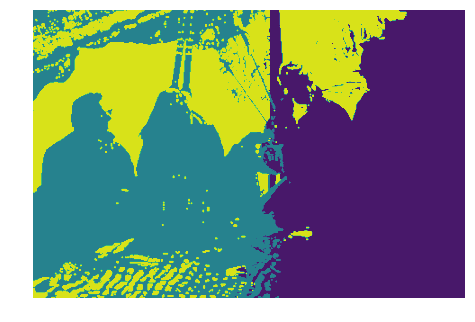

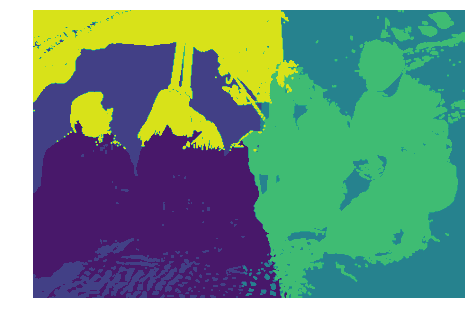

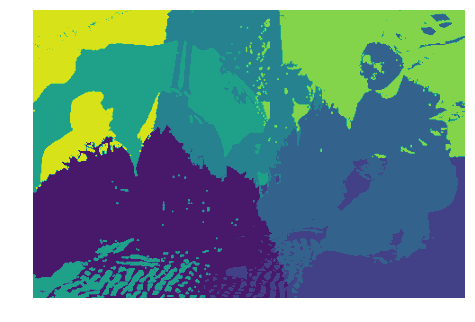

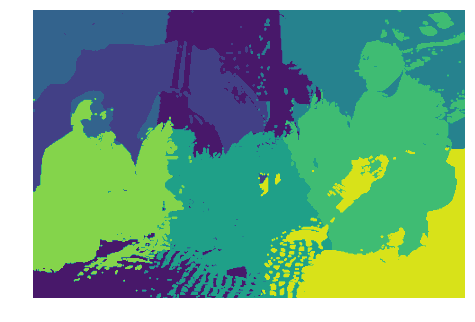

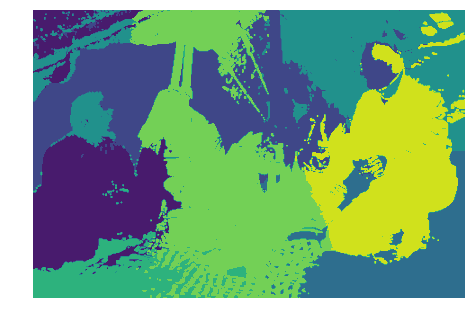

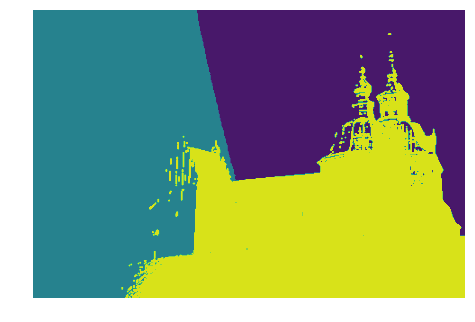

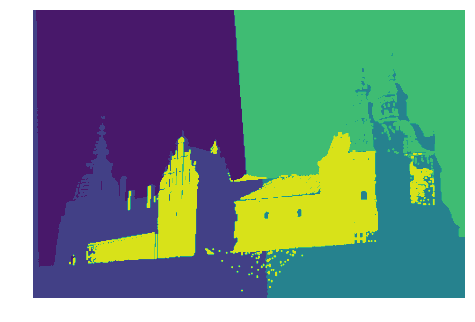

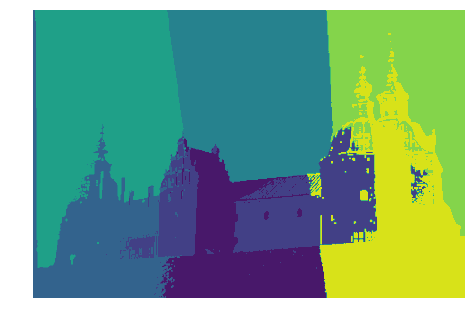

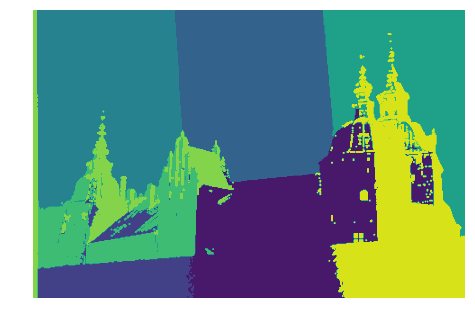

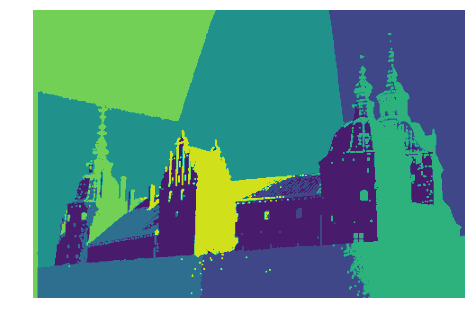

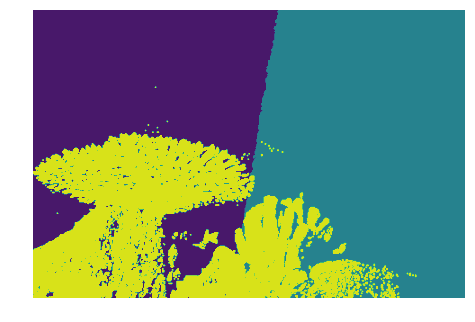

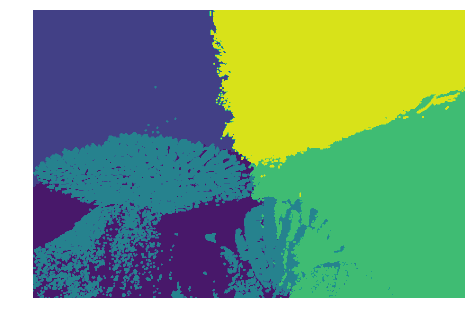

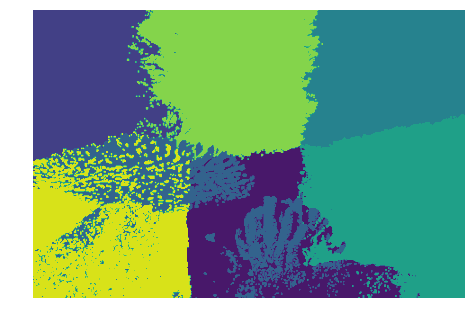

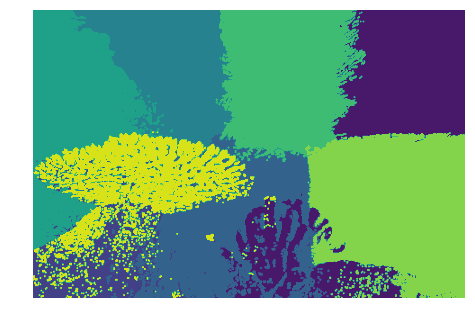

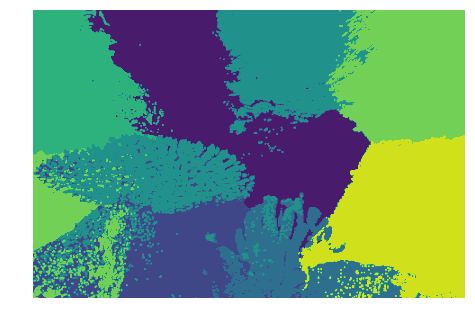

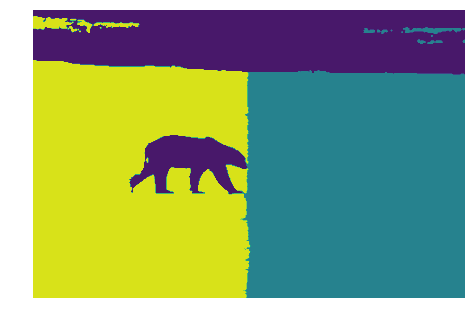

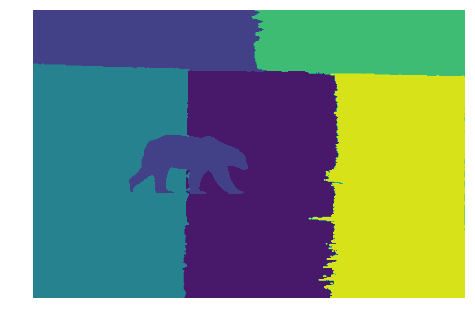

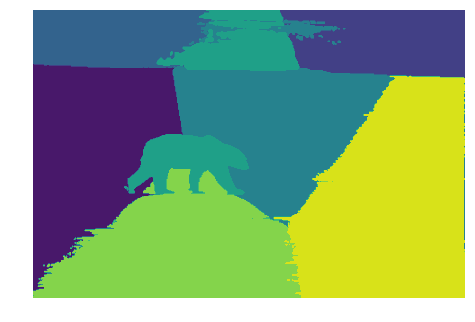

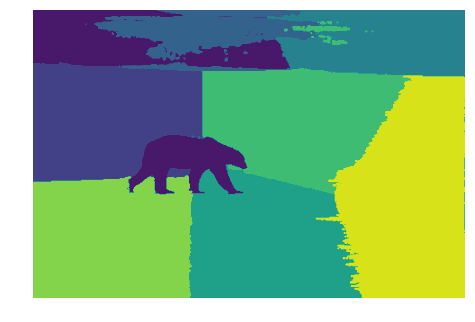

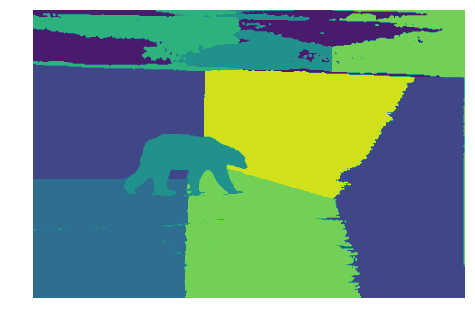

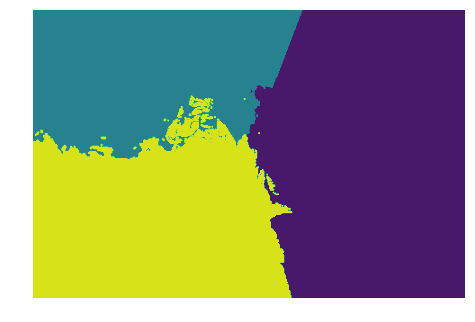

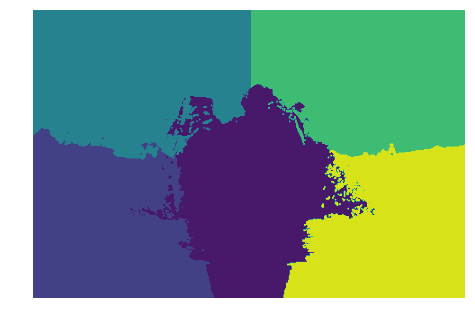

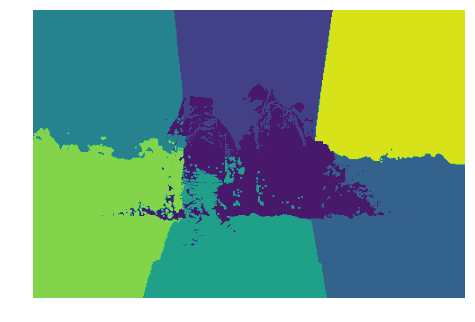

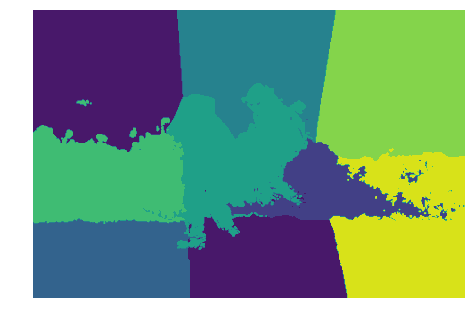

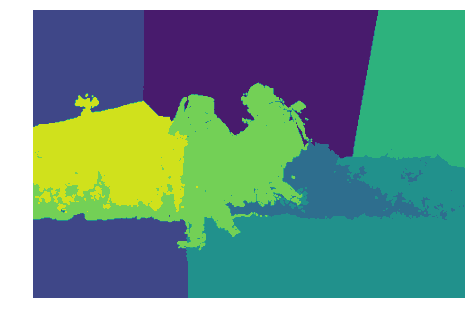

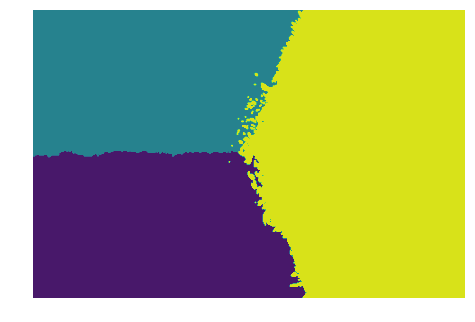

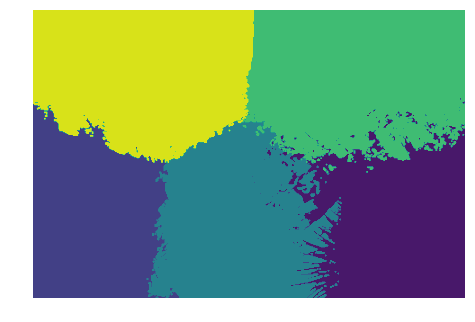

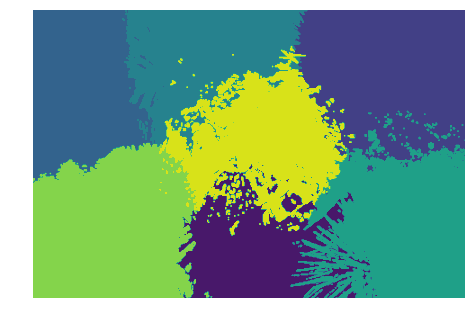

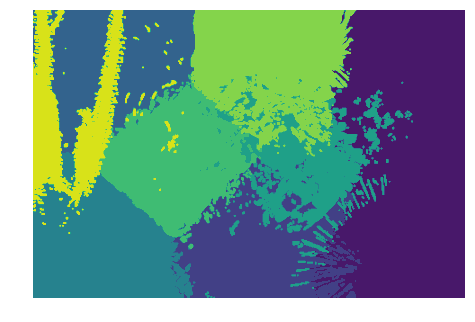

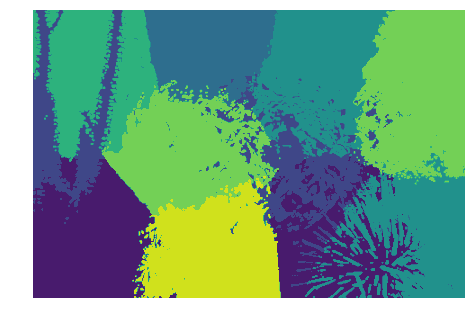

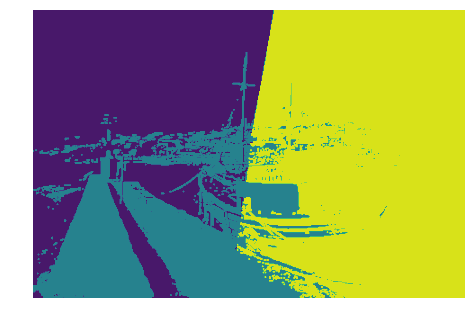

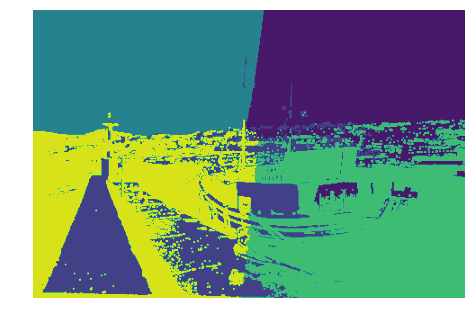

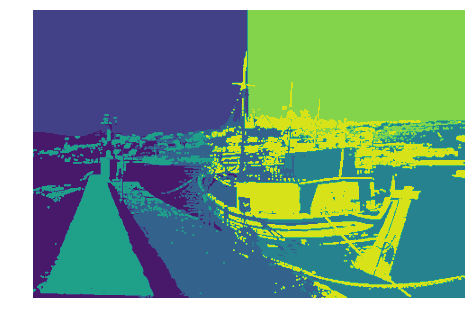

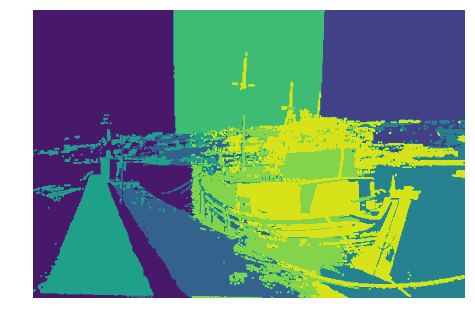

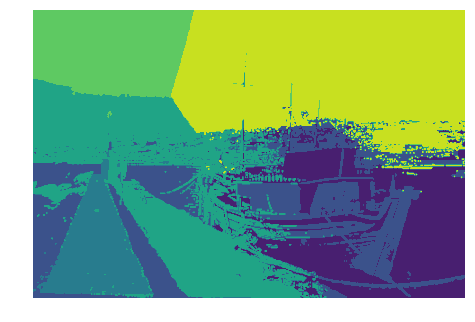

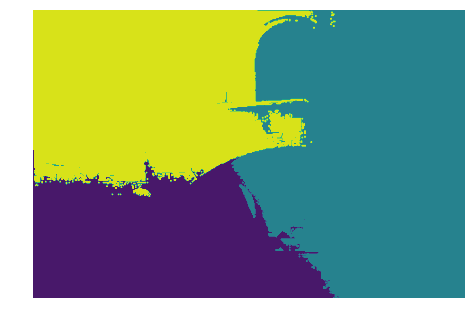

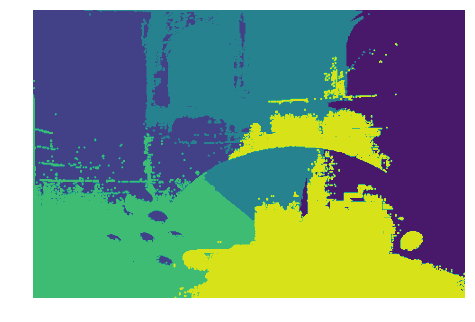

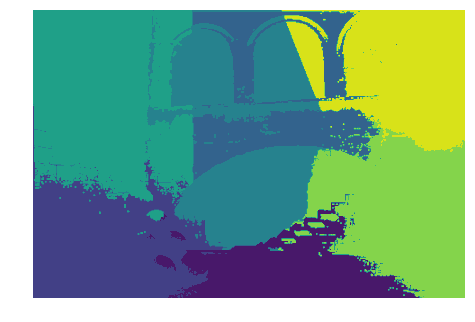

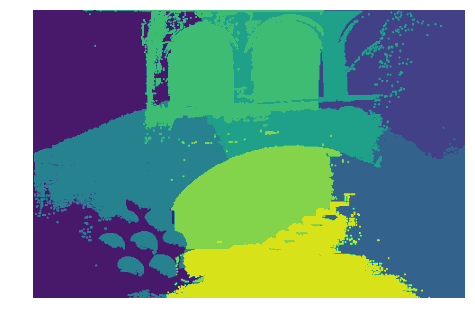

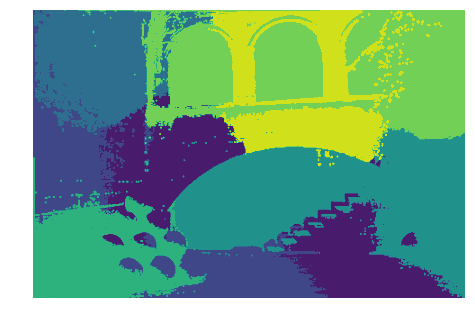

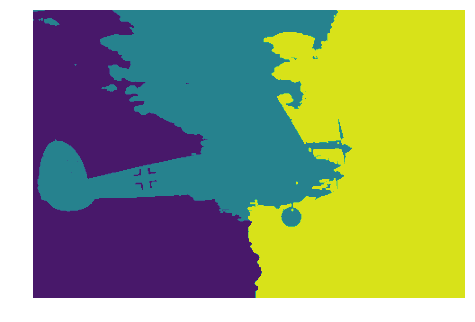

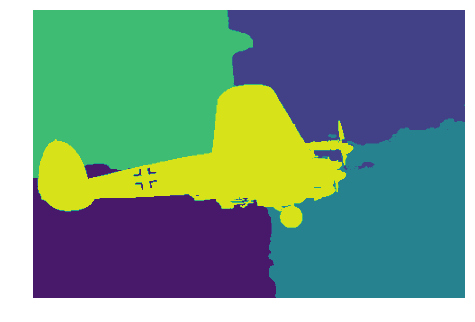

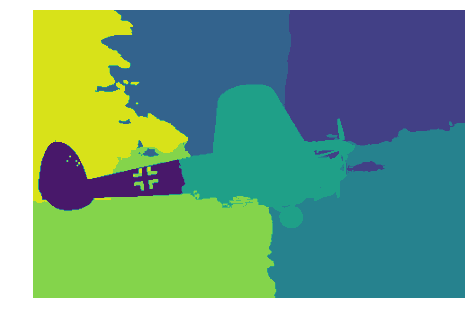

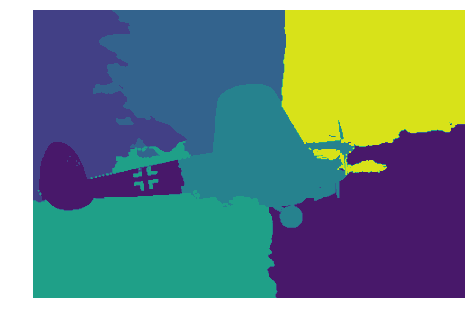

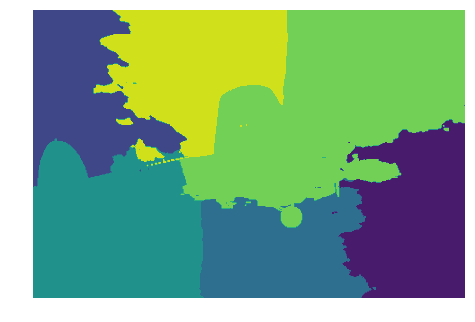

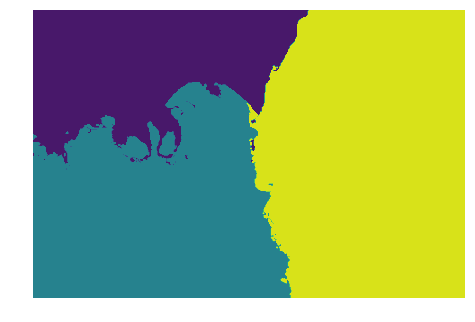

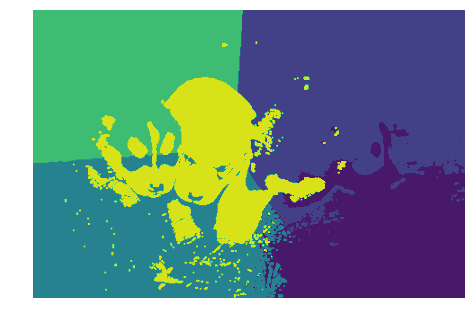

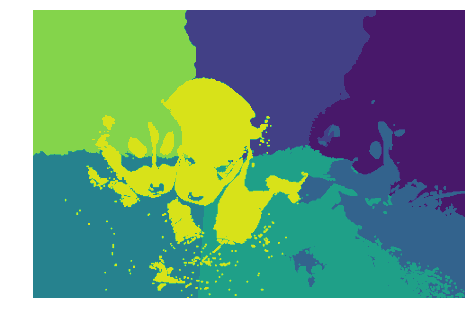

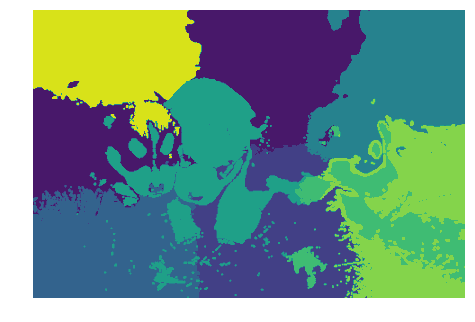

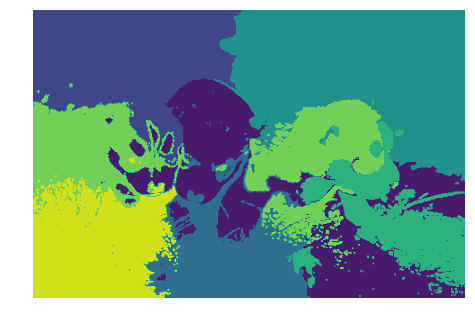

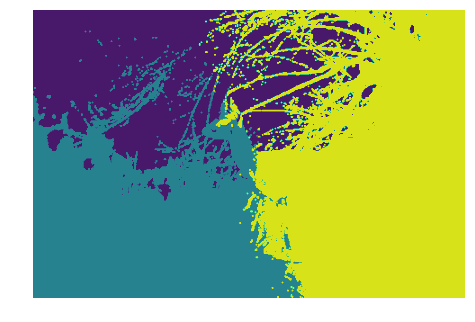

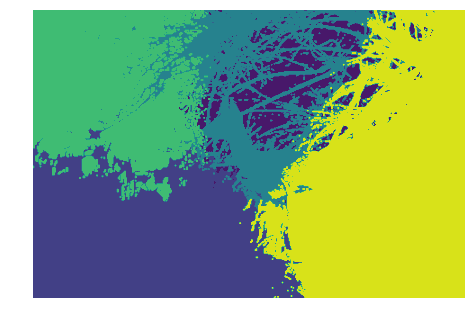

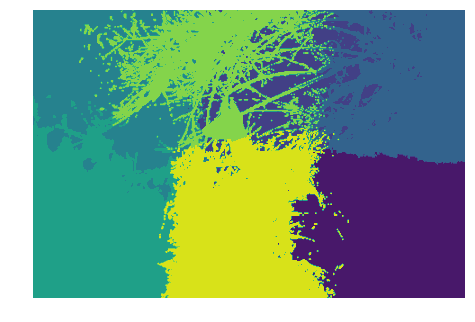

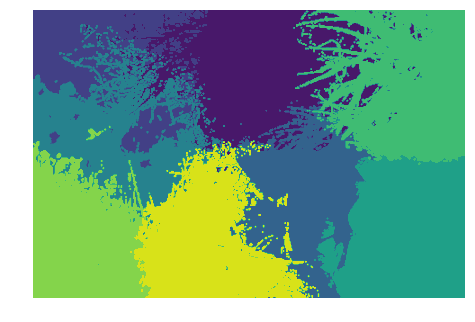

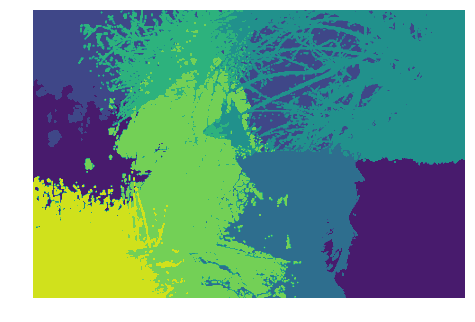

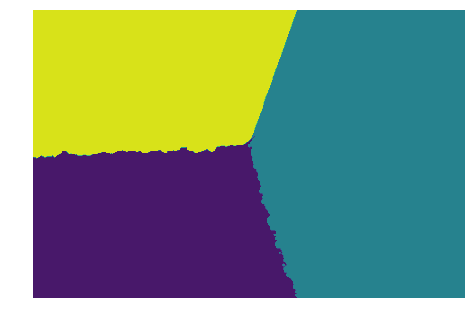

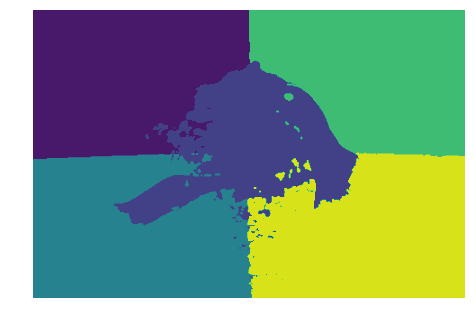

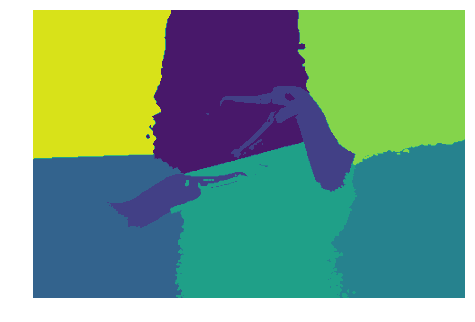

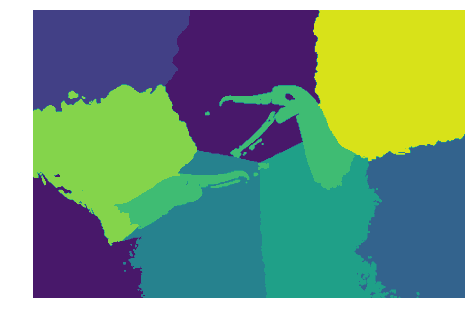

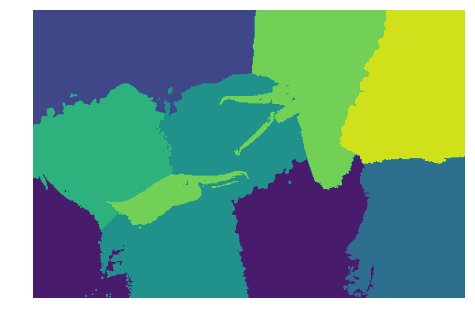

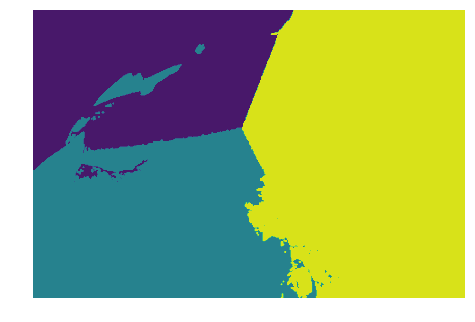

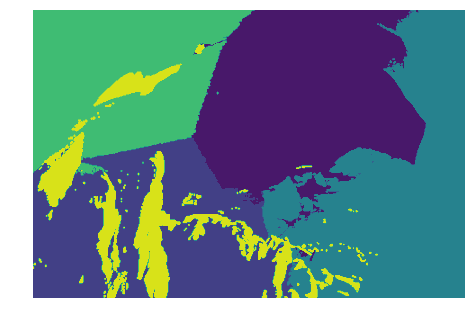

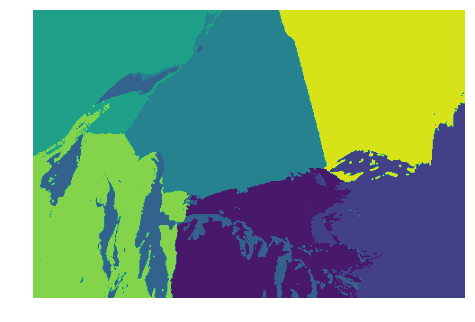

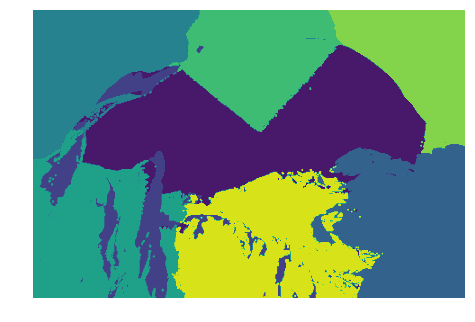

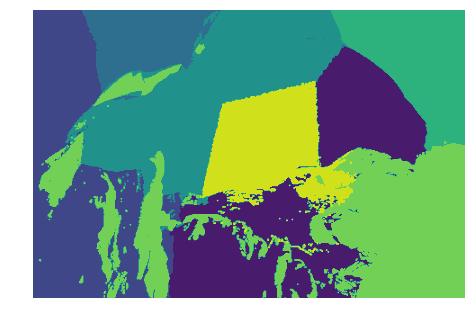

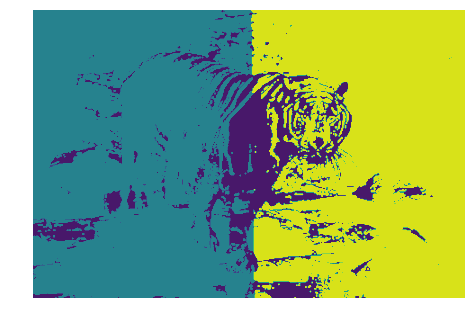

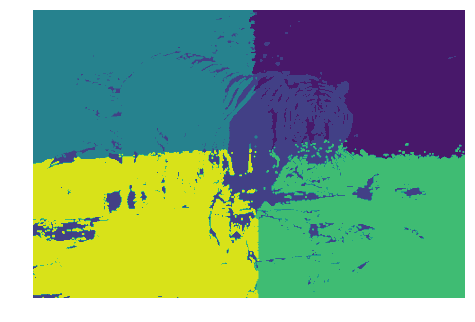

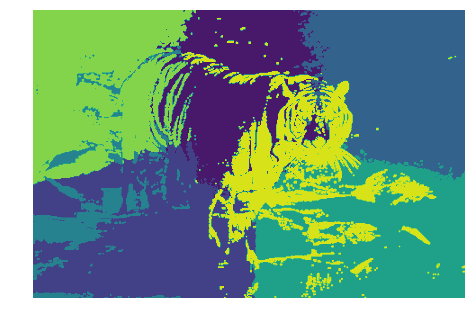

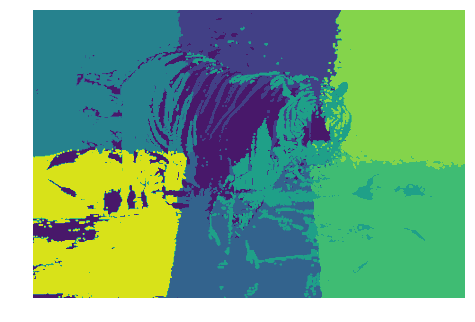

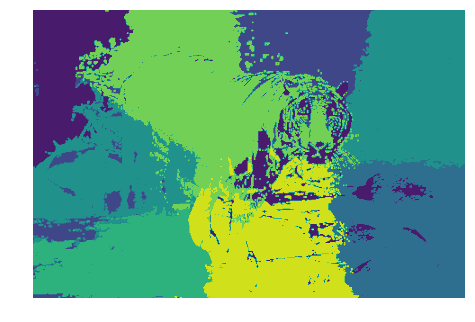

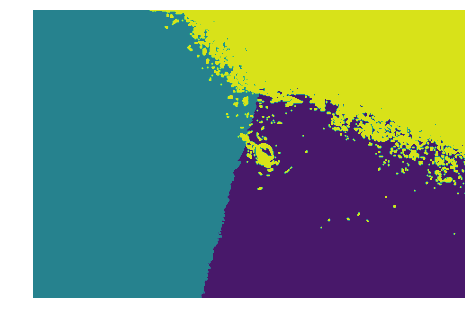

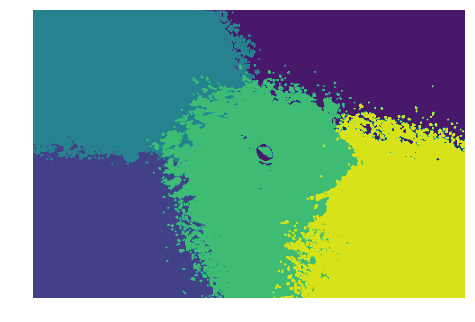

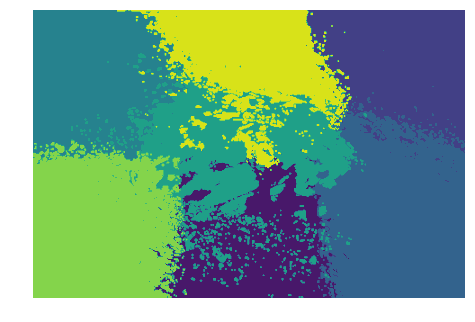

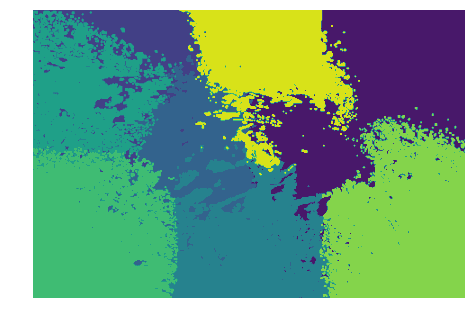

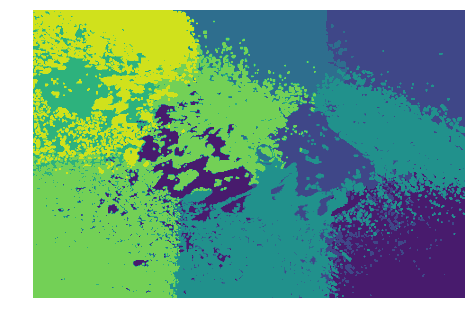

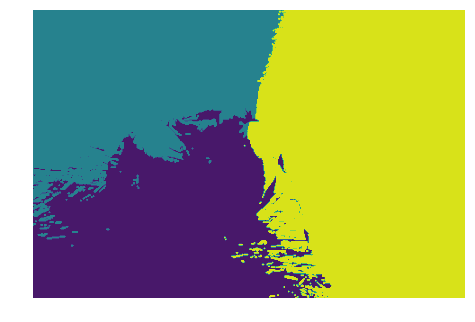

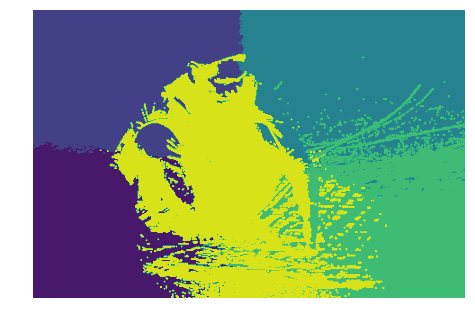

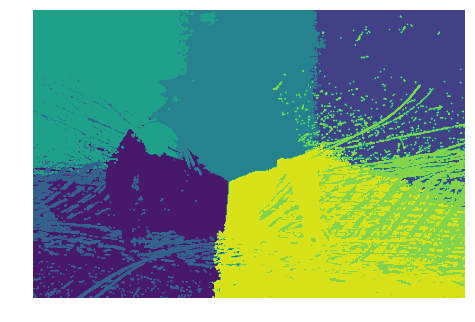

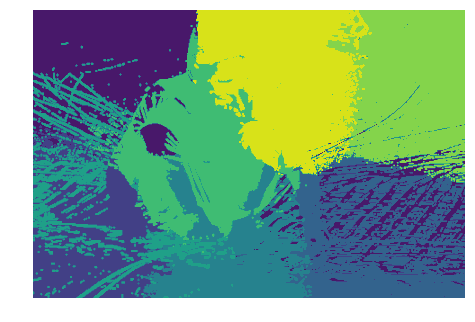

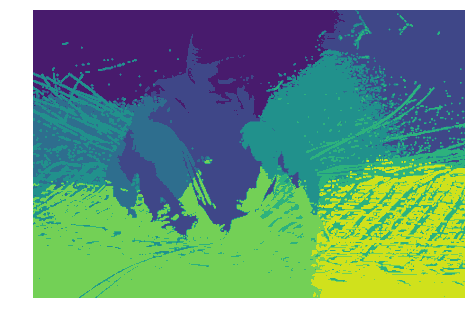

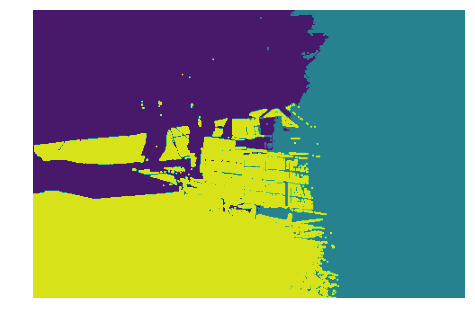

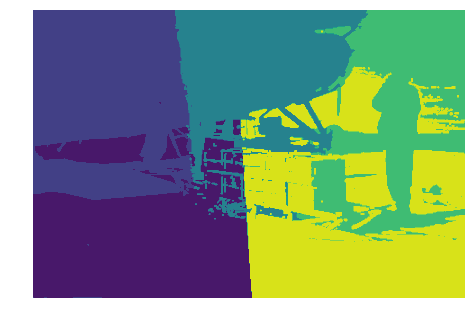

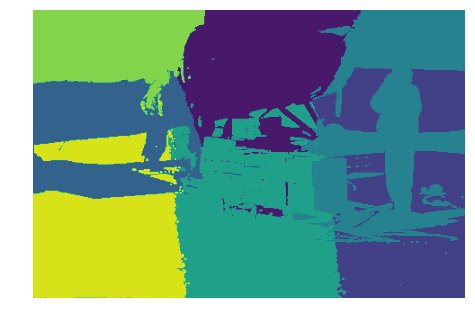

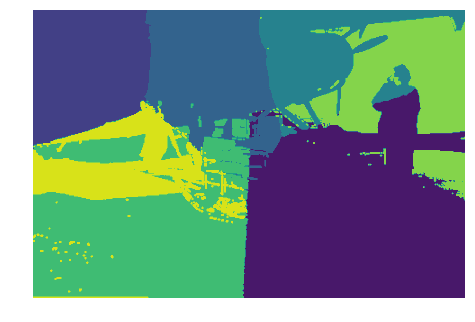

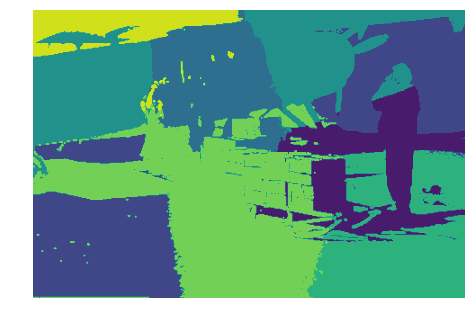

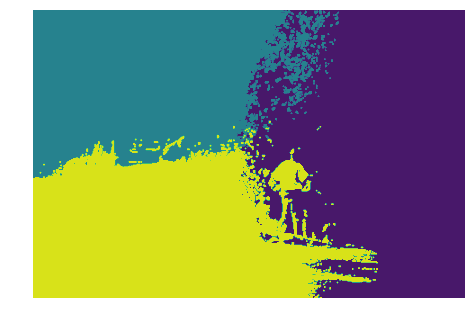

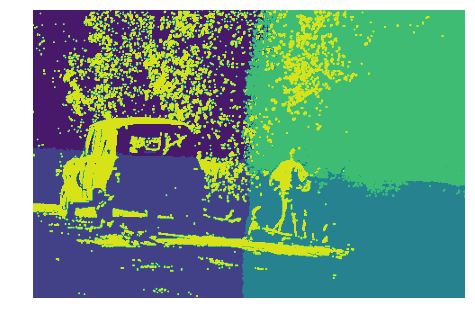

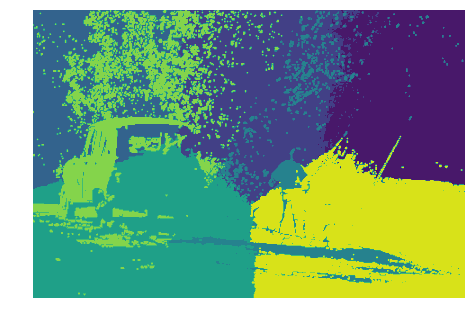

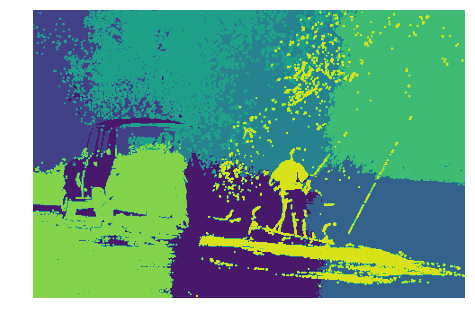

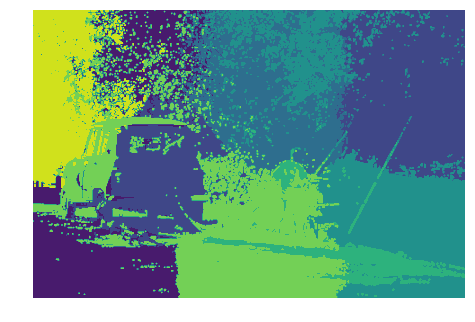

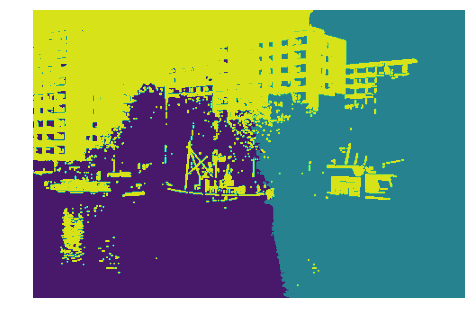

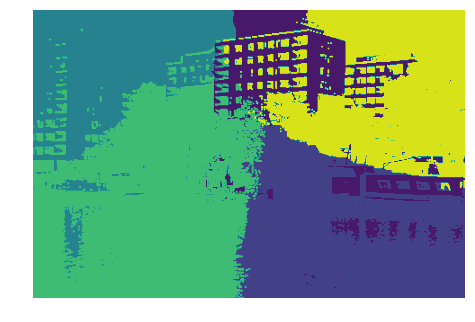

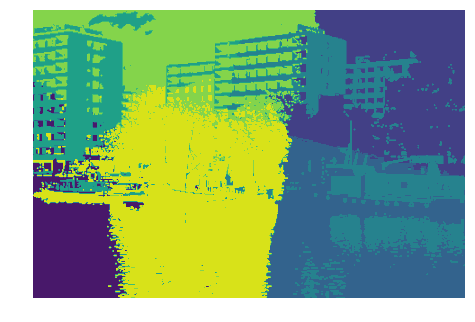

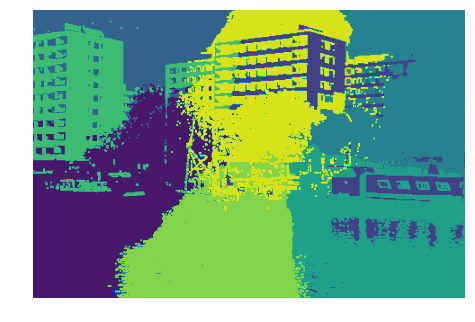

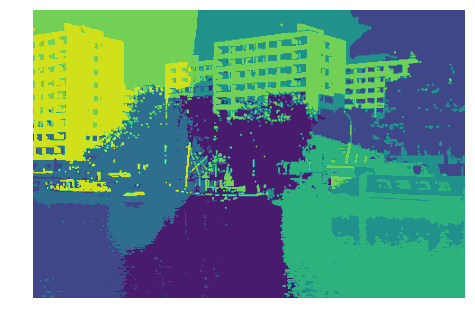

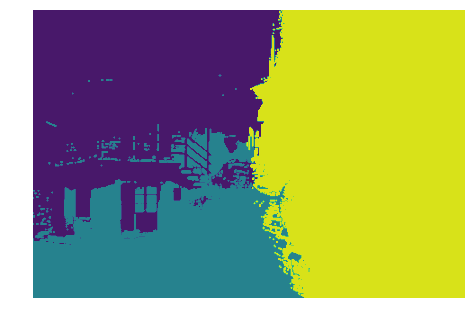

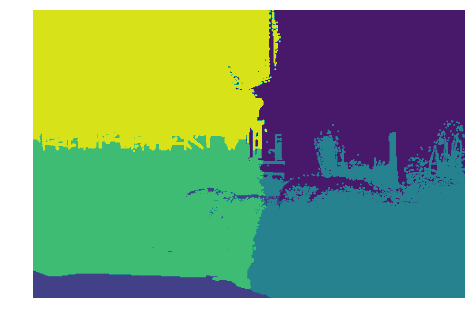

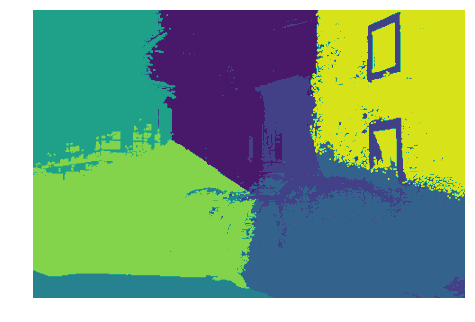

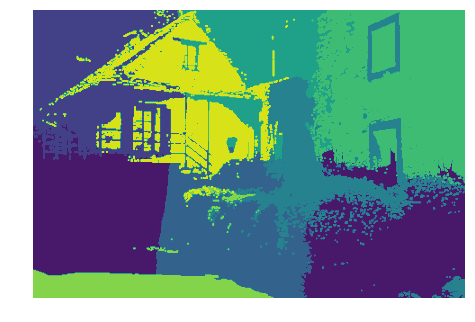

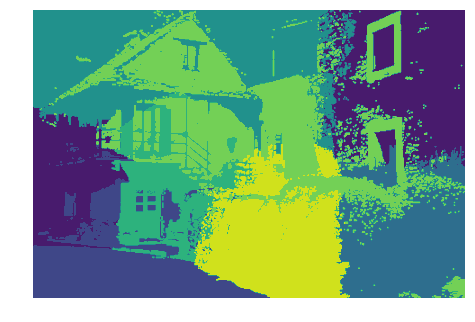

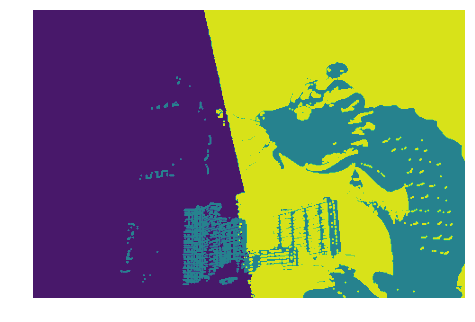

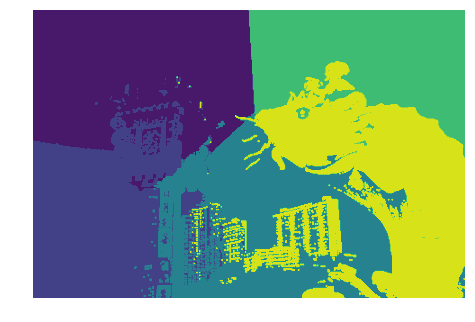

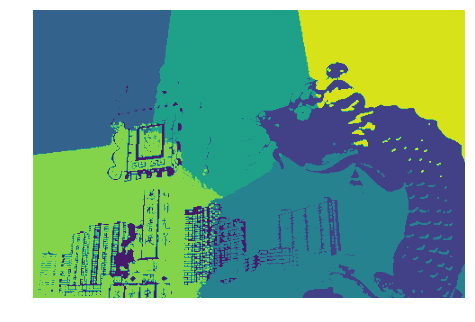

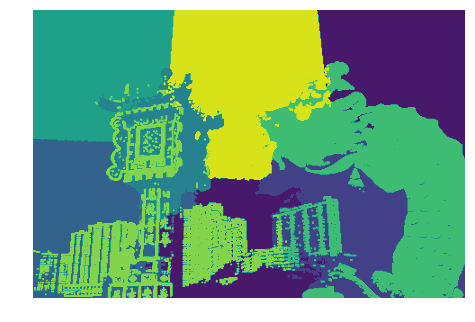

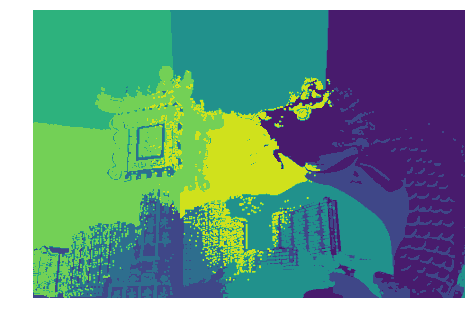

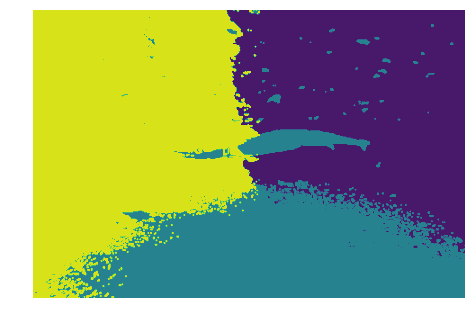

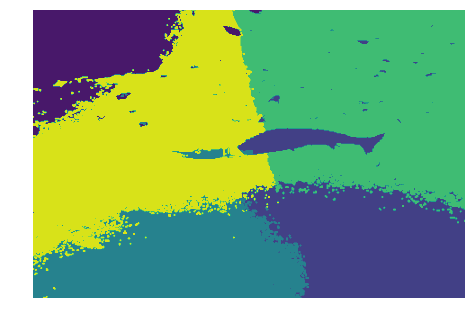

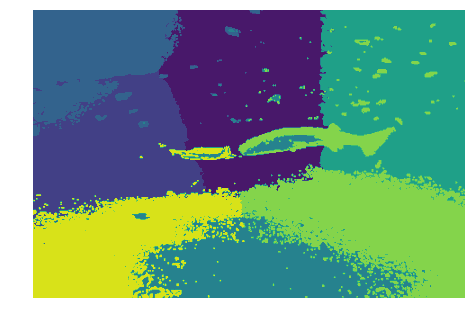

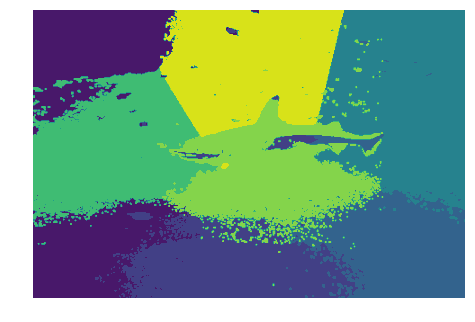

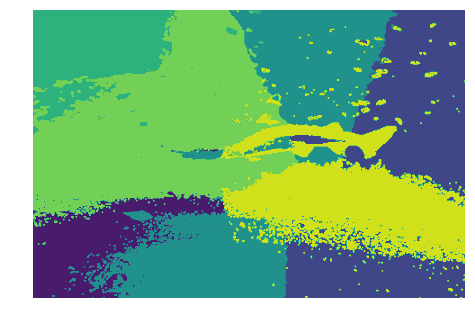

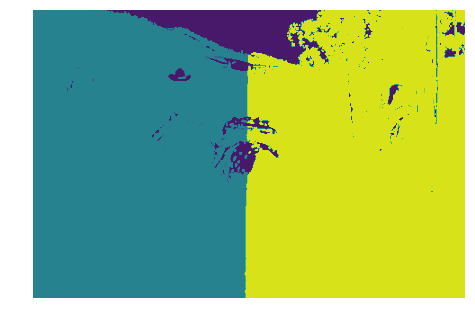

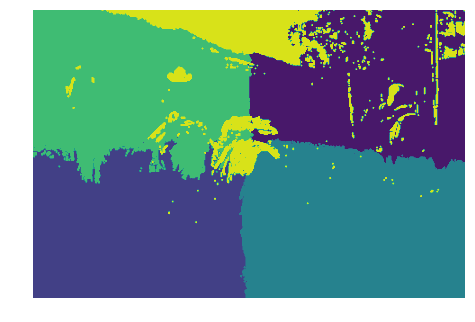

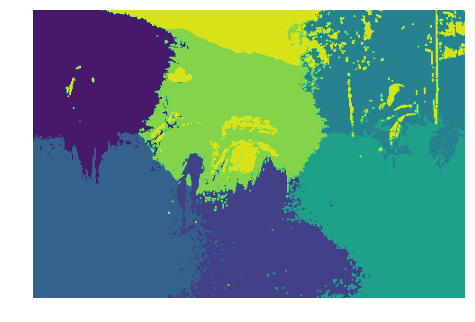

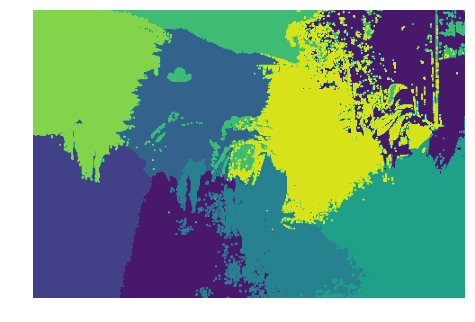

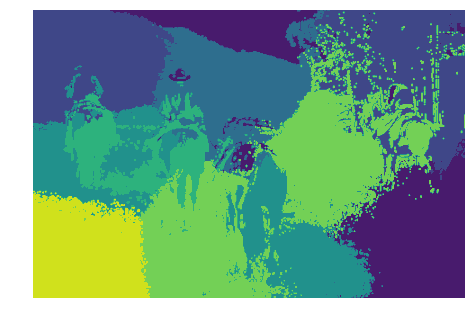

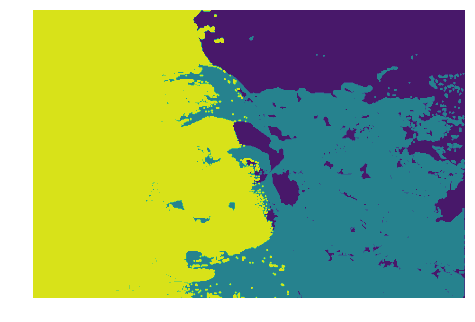

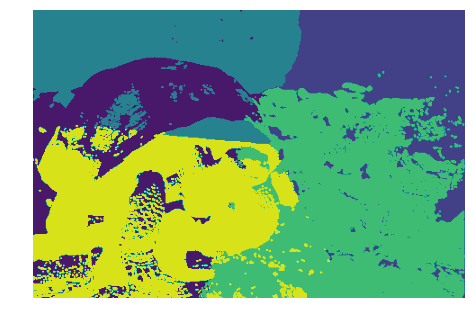

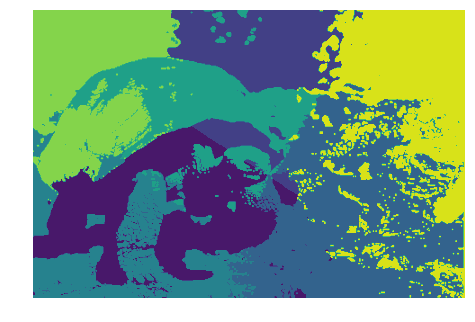

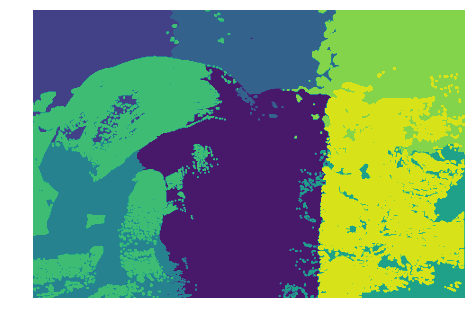

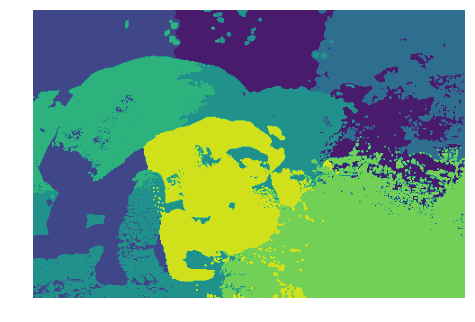

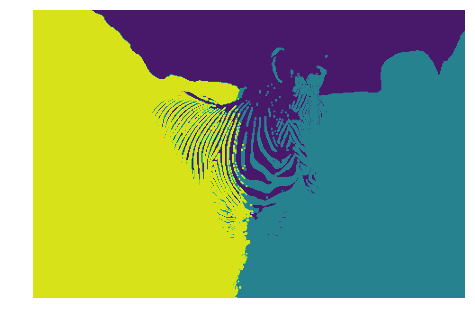

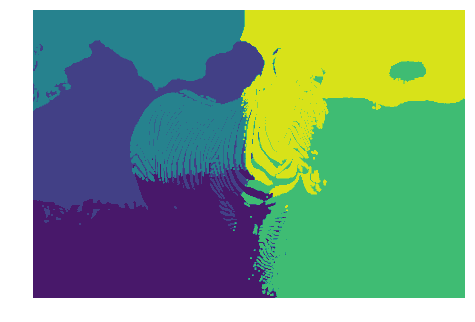

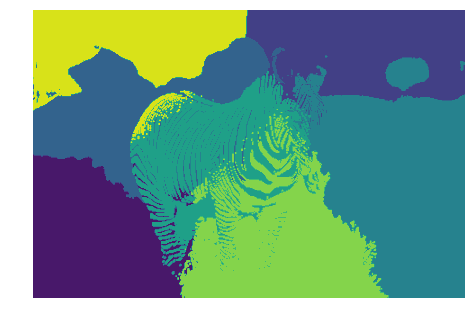

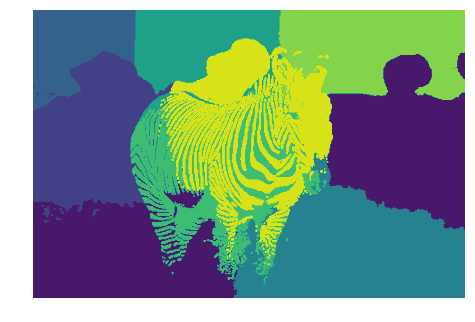

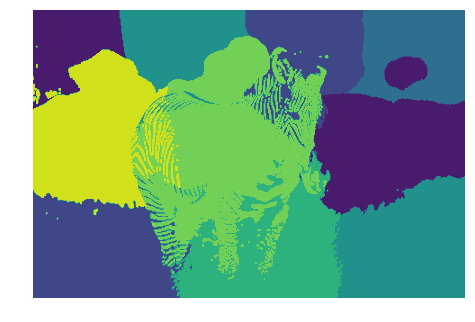

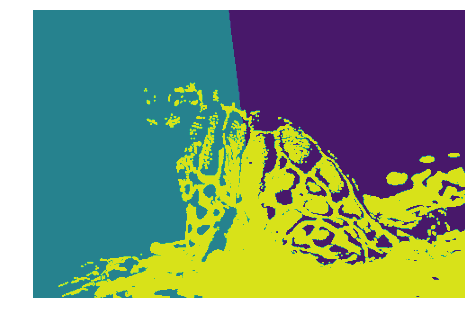

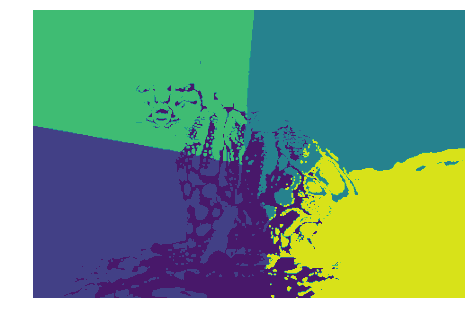

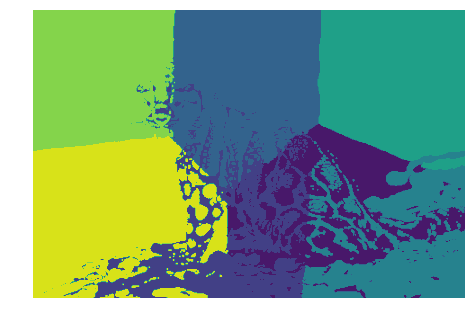

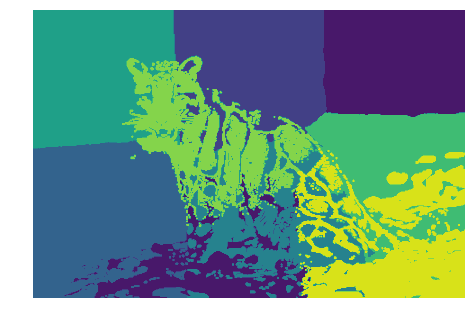

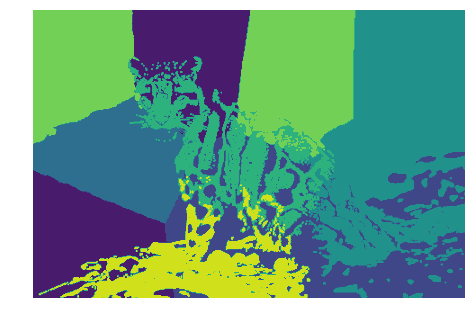

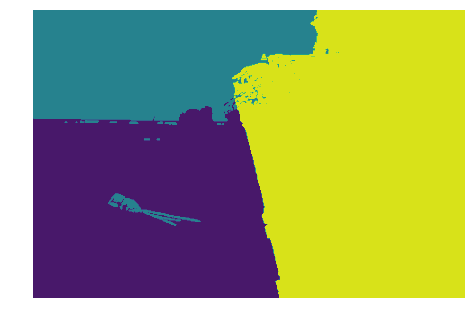

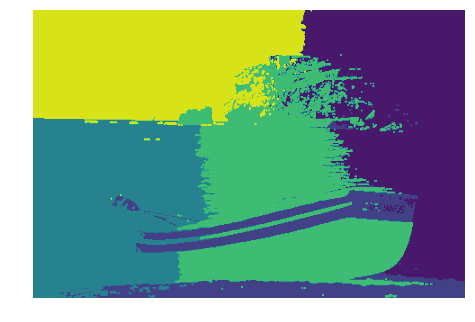

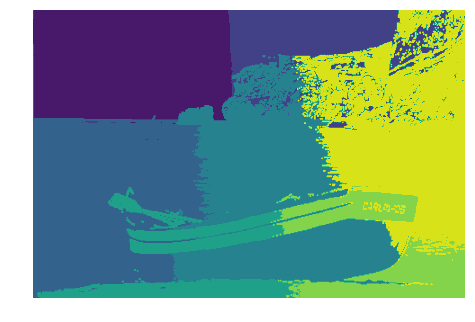

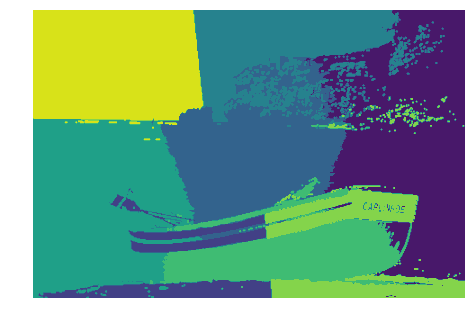

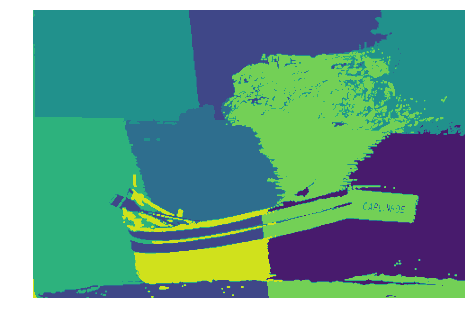

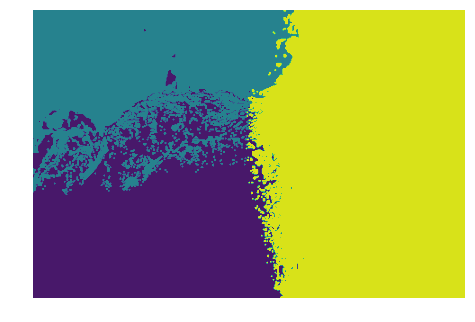

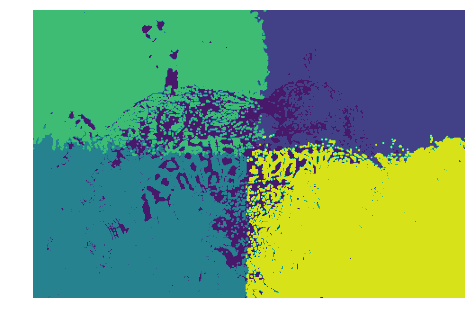

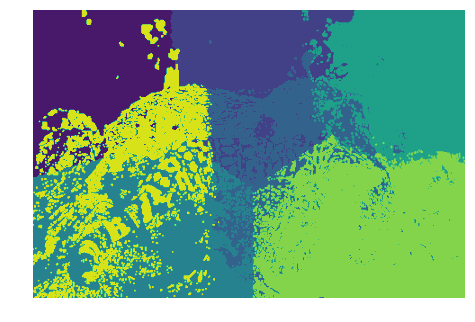

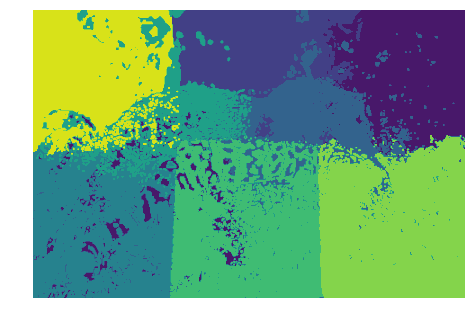

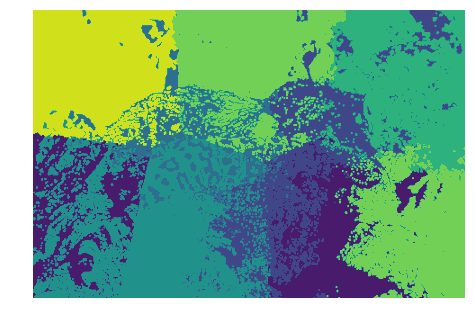

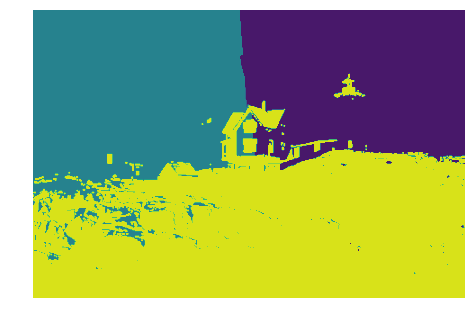

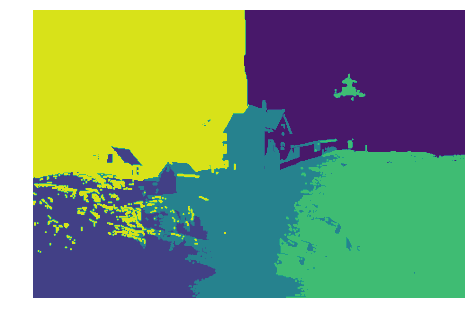

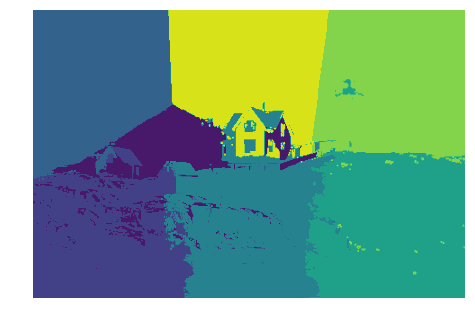

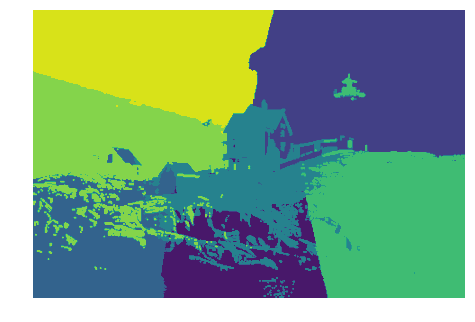

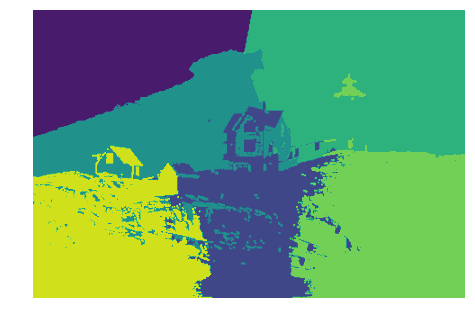

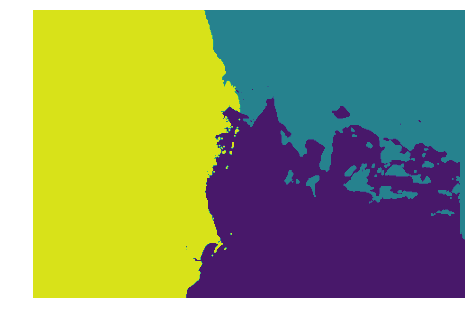

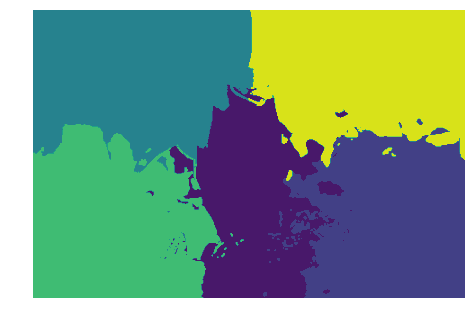

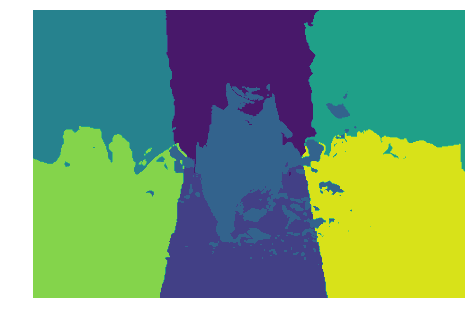

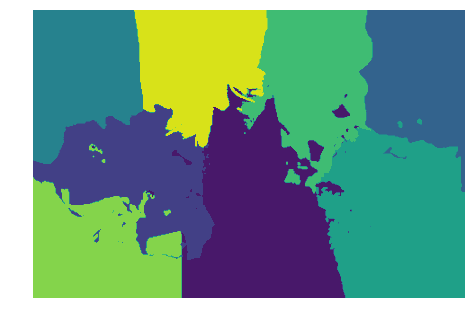

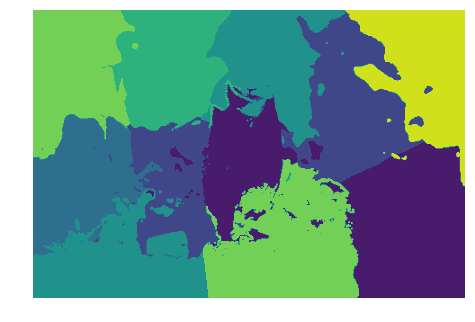

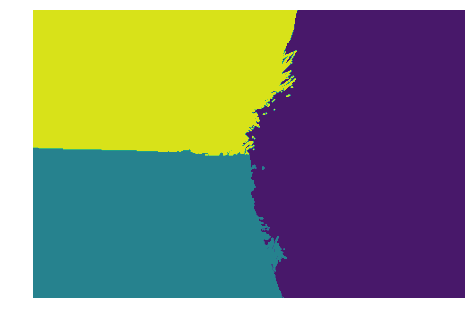

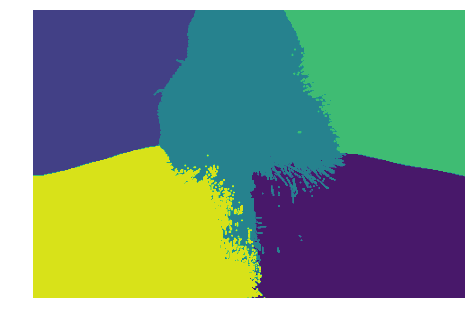

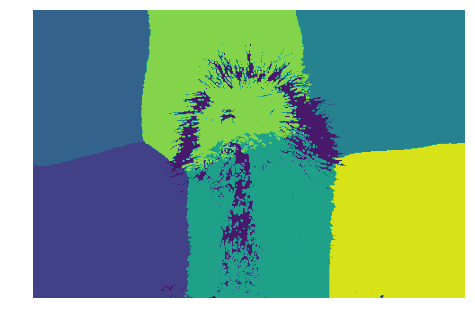

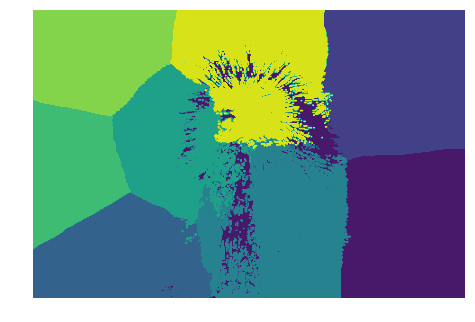

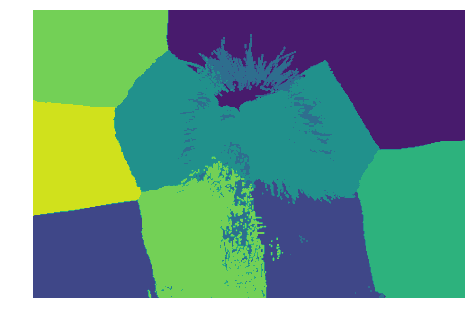

In [26]:
a2 = segment_images(test,root_added_f,added_f=1)

**K-means with spatial features vs Ground Truth**

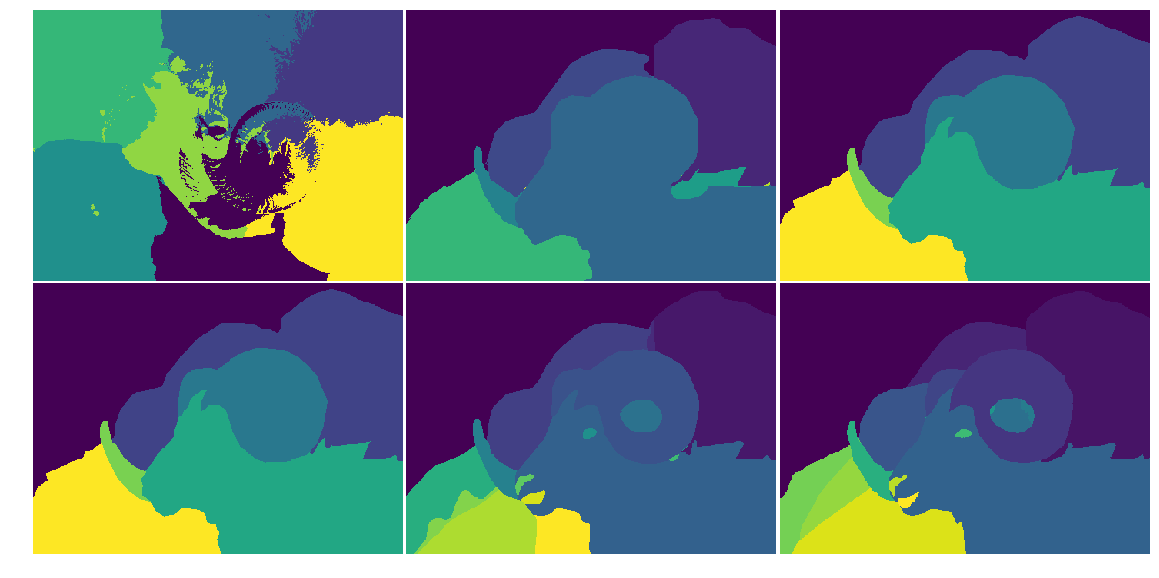

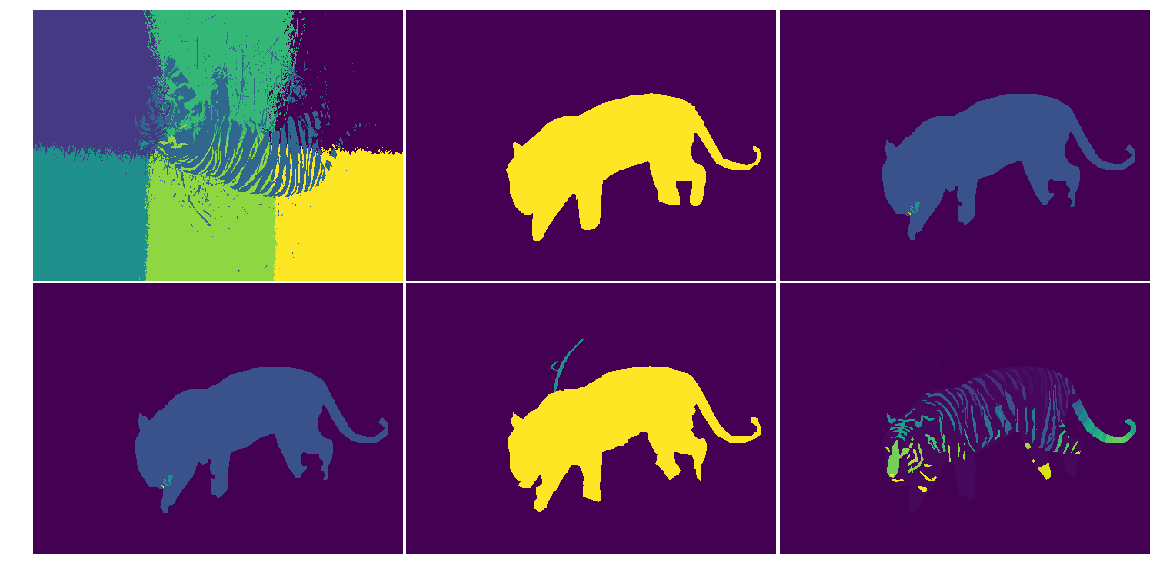

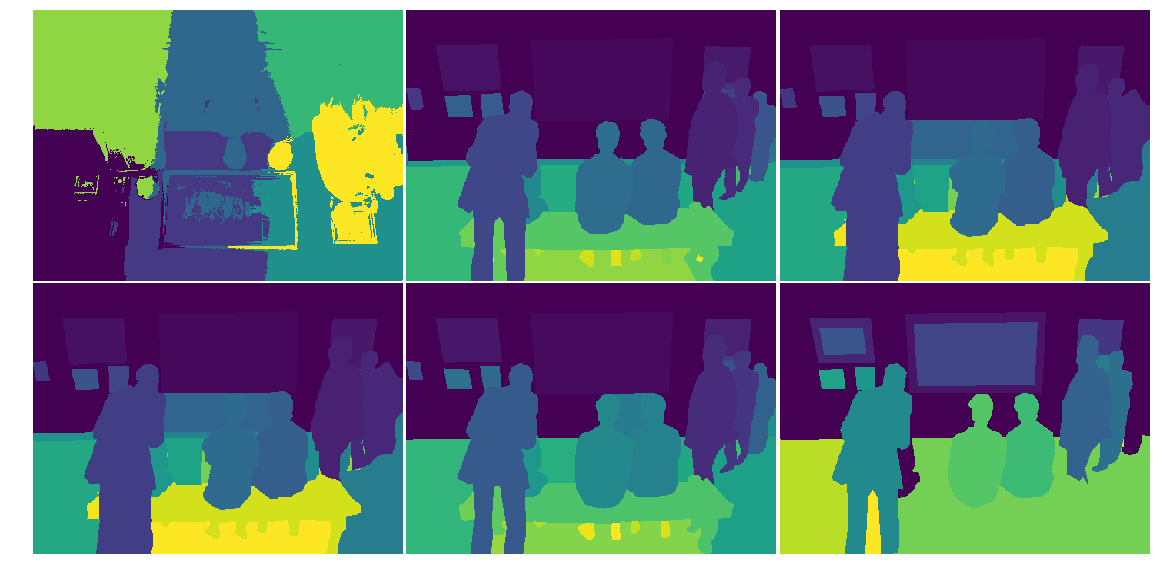

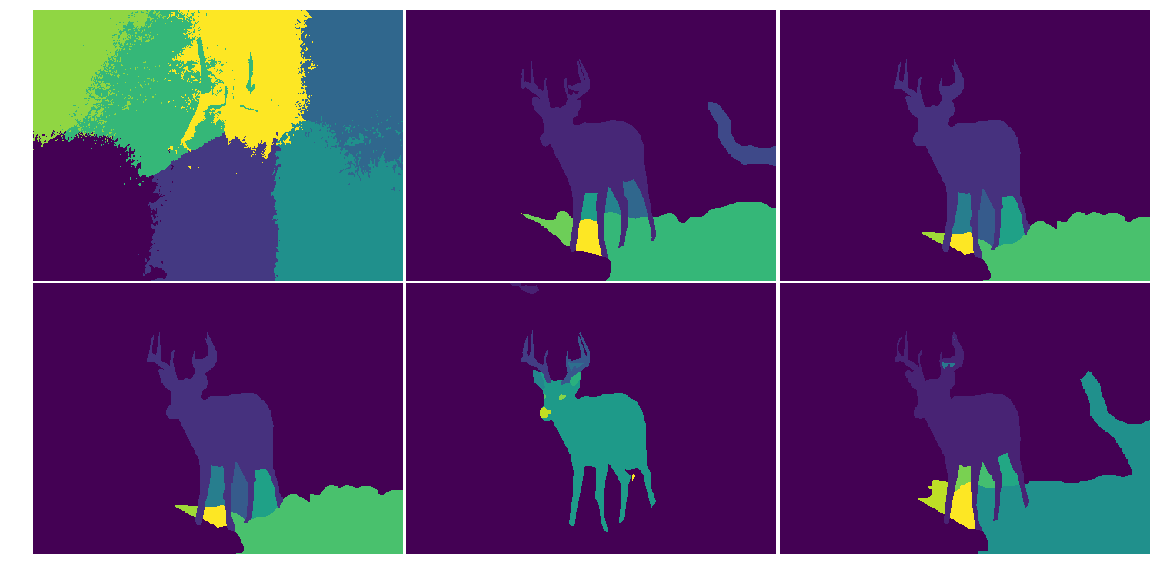

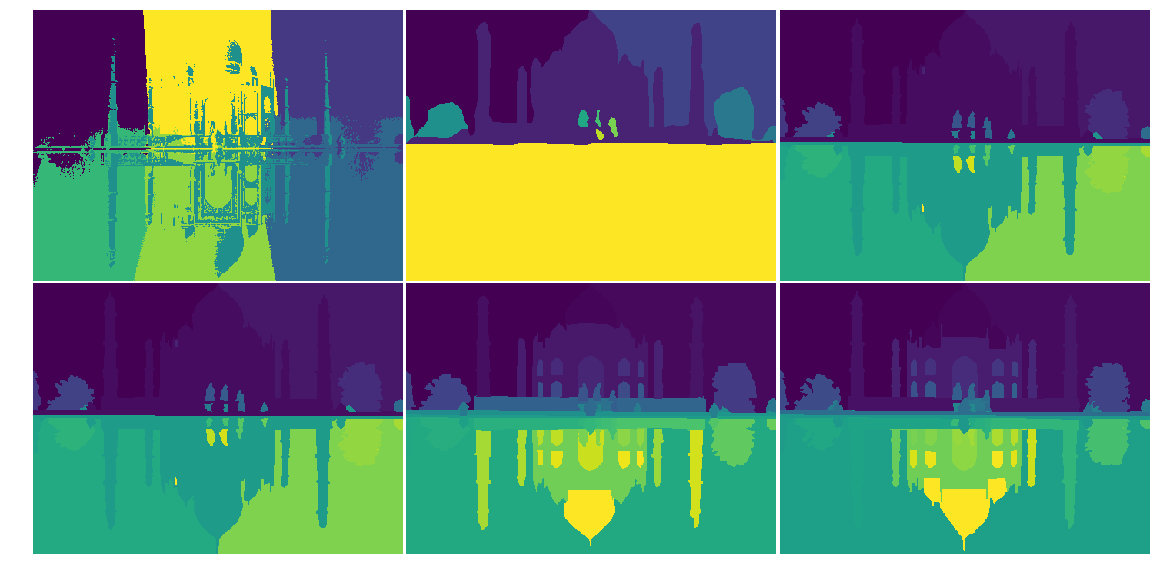

In [27]:
for i in range(0,5):
    display_clustered_and_gt(a2,ground_truth,5+2*i)

**Spectral Clustering with spatial features**

In [85]:
clustered_images_f = evaluate_spectral(test, 0.30,n_images=5,add_spatial=True)

/home/mohamedmahmoud/myprograms/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


clustered image 0
clustered image 1
clustered image 2
clustered image 3
clustered image 4


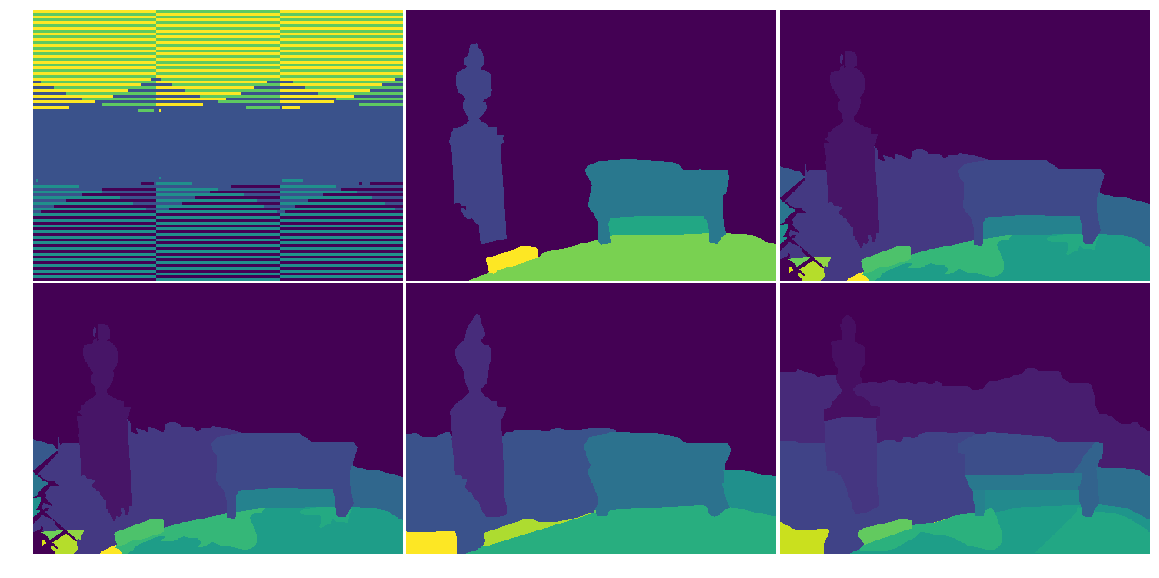

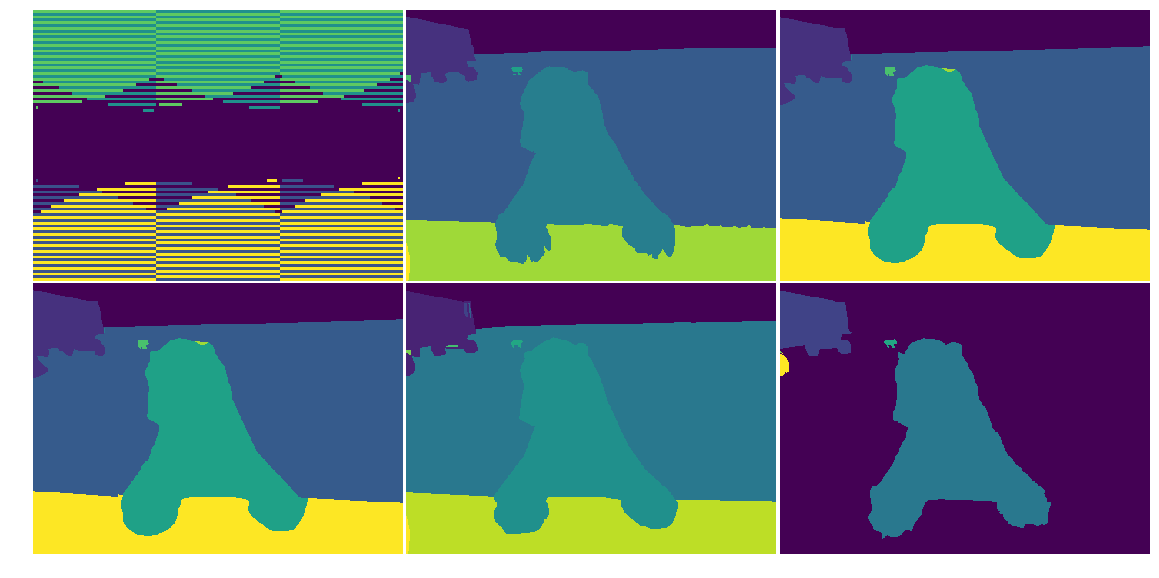

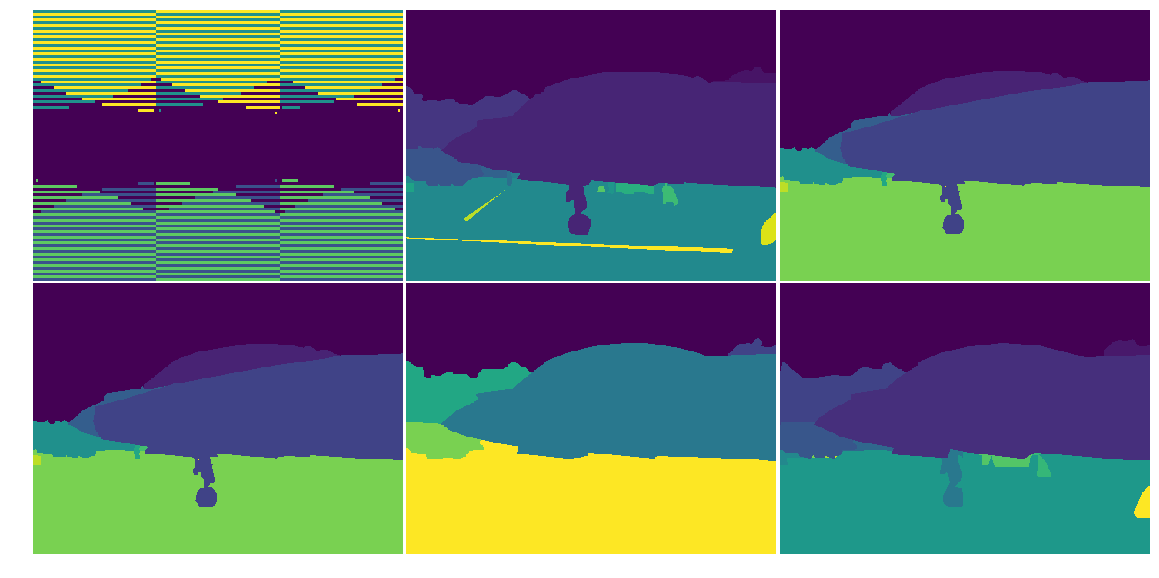

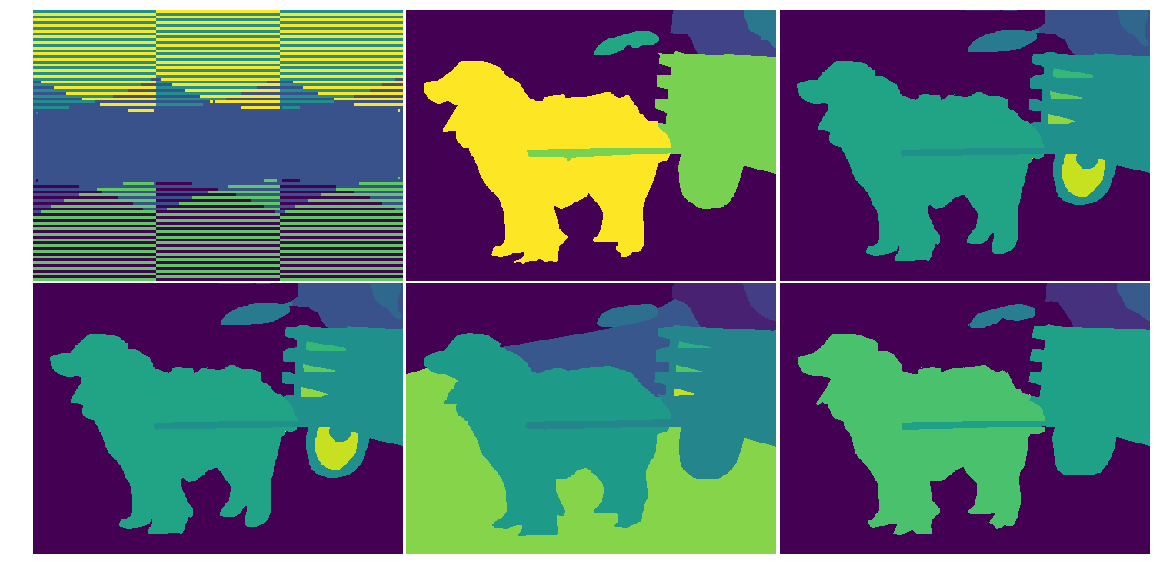

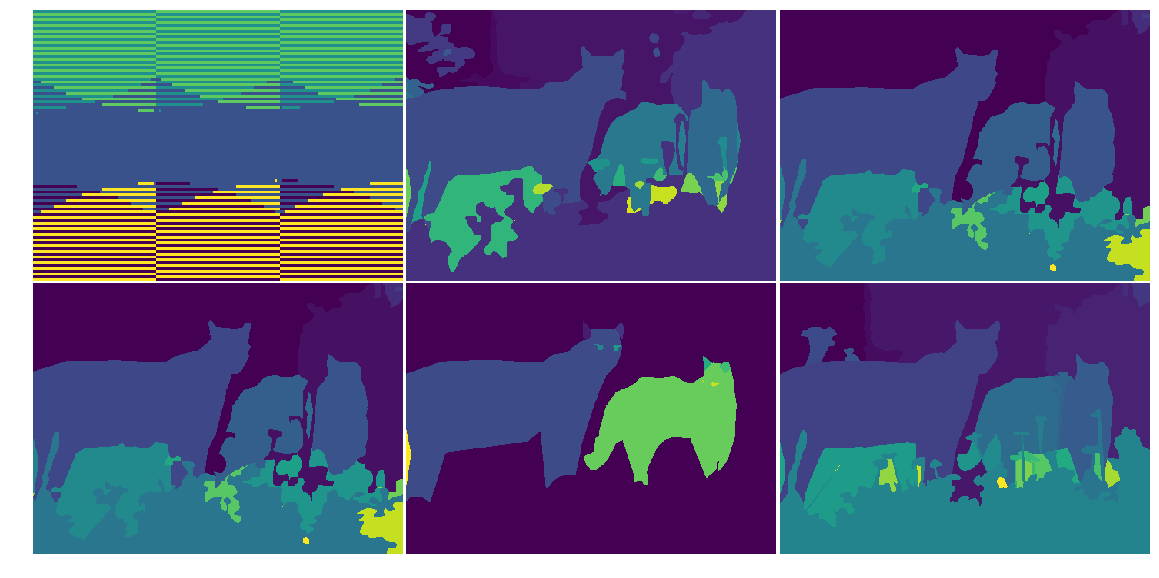

In [86]:
for i in range(0,5):
    display_image_and_gt(clustered_images_f,ground_truth,i)